In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### 1. Base Layer class

In [30]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

### 2. Activation Functions class

In [31]:
class Activation(Layer):
    def __init__(self, activation: str = "relu"):
        self.activation = activation

    def tanh(sefl, x):
        return np.tanh(x)

    def d_tanh(self, x):
        return 1 - np.tanh(x) ** 2

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def relu(self, x):
        return np.maximum(0, x)

    def d_relu(self, x):
        return np.where(x > 0, 1, 0)

    def get_activation(self, X):
        if self.activation == "tanh":
            return self.tanh(X)
        elif self.activation == "sigmoid":
            return self.sigmoid(X)
        elif self.activation == "relu":
            return self.relu(X)
        else:
            raise ValueError("Invalid activation function")

    def get_d_activation(self, dZ):
        if self.activation == "tanh":
            return self.d_tanh(dZ)
        elif self.activation == "sigmoid":
            return self.d_sigmoid(dZ)
        elif self.activation == "relu":
            return self.d_relu(dZ)
        else:
            raise ValueError("Invalid activation function")

    def forward(self, X):
        self.X = X
        return self.get_activation(self.X)

    def backward(self, dZ, learning_rate):
        return np.multiply(dZ, self.get_d_activation(self.X))

### 3. Dense Layer class

In [32]:
class Dense(Layer):
    def __init__(self, input_size: int, output_size: int) -> None:
        """
        :param input_size: size of input vector
        :param output_size: size of output vector
        """
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input: np.ndarray) -> np.ndarray:
        """
        :param input: input vector
        """
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        """
        :param dZ: gradient of loss with respect to output
        :param lr: learning rate
        """
        dW = np.dot(dZ, self.input.T)
        dX = np.dot(self.weights.T, dZ)
        self.weights -= lr * dW
        self.bias -= lr * dZ
        return dX

### 4. Loss Functions class

In [33]:
class Loss:
    def __init__(
        self, loss: str = "mse", y_true: np.ndarray = None, y_pred: np.ndarray = None
    ) -> None:
        """
        :param loss: str, loss function (Available: mse, bce)
        :param y_true: np.ndarray, true values
        :param y_pred: np.ndarray, predicted values
        """
        self.loss = loss
        self.y_true = y_true
        self.y_pred = y_pred

    # Mean Squared Error
    def mse(self) -> float:
        return np.mean(np.power(self.y_true - self.y_pred, 2))

    def d_mse(self) -> float:
        return 2 * (self.y_pred - self.y_true) / np.size(self.y_true)

    # Binary Cross Entropy
    def bce(self) -> float:
        return np.mean(
            -self.y_true * np.log(self.y_pred)
            - (1 - self.y_true) * np.log(1 - self.y_pred)
        )

    def d_bce(self) -> float:
        return (
            (1 - self.y_true) / (1 - self.y_pred) - self.y_true / self.y_pred
        ) / np.size(self.y_true)

    def get_loss(self) -> float:
        if self.loss == "mse":
            return self.mse()
        if self.loss == "bce":
            return self.bce()

    def get_d_loss(self) -> float:
        if self.loss == "mse":
            return self.d_mse()
        if self.loss == "bce":
            return self.d_bce()

### 5. Multi Layer Perceptron class

In [34]:
class MLP:
    def __init__(self, layer: list[Layer]) -> None:
        self.layers = layer

    def summary(self) -> None:
        len_assigned = [45, 26, 15]
        count = {"Dense": 0, "Activation": 0, "Input": 0}
        col_names = ["Layer", "Output Shape", "Param #"]

        print("Model: Multi Layer Perceptron")
        print("-" * sum(len_assigned))

        text = ""
        for i in range(len(col_names)):
            text += col_names[i] + " " * (len_assigned[i] - len(col_names[i]))
        print(text)

        print("=" * sum(len_assigned))

        for i in range(len(self.layers)):
            layer_name = self.layers[i].__class__.__name__
            if layer_name == "Activation":
                continue

            name = f"{layer_name.lower()}_{count[layer_name]+1}"
            count[layer_name] += 1

            # Output Shape
            try:
                out = "(None, "
                for j in range(len(self.layers[i].weights.shape)):
                    out += f"{self.layers[i].weights.shape[j]}, "
                out = out[:-2] + ")"
            except AttributeError:
                out = "(None, 1)"

            # Number of Parameters
            if layer_name == "Dense":
                param = self.layers[i].weights.size + self.layers[i].bias.size
            else:
                param = 0

            names = [name, out, str(param)]
            text = ""
            for i in range(len(col_names)):
                text += names[i] + " " * (len_assigned[i] - len(names[i]))
            print(text)

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        epochs: int,
        learning_rate: float,
        verbose: bool = False,
    ) -> None:
        self.history = {
            "Training Loss": [],
            "Training Accuracy": [],
        }

        for epoch in range(epochs):
            cost_train = 0
            y_pred_train = []
            y_train = []

            if verbose:
                print(f"Epoch: {epoch+1}/{epochs}")

            for i in tqdm(range(len(X))):
                Z = X[i]

                for layer in self.layers:
                    Z = layer.forward(Z)

                y_pred_train += np.abs(np.round(Z)).tolist()
                y_train += (y[i]).tolist()

                cost_train += Loss(y_true=y[i], y_pred=Z).get_loss()

                dZ = Loss(y_true=y[i], y_pred=Z).get_d_loss()
                for layer in reversed(self.layers):
                    dZ = layer.backward(dZ, learning_rate)

            text = "Training Loss: " + str(round(cost_train, 4)) + " - "
            self.history["Training Loss"].append(cost_train)

            acc = np.sum(np.array(y_pred_train) == np.array(y_train)) / len(y_train)
            text += "Training Accuracy: " + str(round(acc, 4))
            self.history["Training Accuracy"].append(acc)

            if verbose:
                print(text)

    def loss_plot(self) -> None:
        plt.plot(self.history["Training Loss"], label="Training Loss")
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def accuracy_plot(self) -> None:
        plt.plot(self.history["Training Accuracy"], label="Training Accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

    def predict(self, X: np.ndarray):
        out = []
        for x in X:
            for layer in self.layers:
                x = layer.forward(x).flatten()
            out.append(x)

        return np.array(out)

### Testing Model with XOR gate

In [35]:
X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

In [36]:
epochs = 1000
lr = 0.01

In [37]:
mlp = MLP([Dense(2, 3), Activation("tanh"), Dense(3, 1), Activation("tanh")])

In [38]:
mlp.summary()

Model: Multi Layer Perceptron
--------------------------------------------------------------------------------------
Layer                                        Output Shape              Param #        
dense_1                                      (None, 3, 2)              9              
dense_2                                      (None, 1, 3)              4              


In [39]:
mlp.fit(X, Y, epochs, lr, verbose=True)

Epoch: 1/1000


100%|██████████| 4/4 [00:00<00:00, 7384.34it/s]


Training Loss: 2.6461 - Training Accuracy: 0.25
Epoch: 2/1000


100%|██████████| 4/4 [00:00<00:00, 6234.57it/s]


Training Loss: 2.4142 - Training Accuracy: 0.25
Epoch: 3/1000


100%|██████████| 4/4 [00:00<00:00, 6415.76it/s]


Training Loss: 2.2157 - Training Accuracy: 0.25
Epoch: 4/1000


100%|██████████| 4/4 [00:00<00:00, 6295.39it/s]


Training Loss: 2.0494 - Training Accuracy: 0.25
Epoch: 5/1000


100%|██████████| 4/4 [00:00<00:00, 9044.32it/s]


Training Loss: 1.9123 - Training Accuracy: 0.25
Epoch: 6/1000


100%|██████████| 4/4 [00:00<00:00, 8872.14it/s]


Training Loss: 1.8004 - Training Accuracy: 0.25
Epoch: 7/1000


100%|██████████| 4/4 [00:00<00:00, 6019.81it/s]


Training Loss: 1.7095 - Training Accuracy: 0.25
Epoch: 8/1000


100%|██████████| 4/4 [00:00<00:00, 6307.22it/s]


Training Loss: 1.6357 - Training Accuracy: 0.25
Epoch: 9/1000


100%|██████████| 4/4 [00:00<00:00, 6340.60it/s]


Training Loss: 1.5756 - Training Accuracy: 0.25
Epoch: 10/1000


100%|██████████| 4/4 [00:00<00:00, 6120.84it/s]


Training Loss: 1.5265 - Training Accuracy: 0.25
Epoch: 11/1000


100%|██████████| 4/4 [00:00<00:00, 6452.78it/s]


Training Loss: 1.4861 - Training Accuracy: 0.25
Epoch: 12/1000


100%|██████████| 4/4 [00:00<00:00, 10929.78it/s]


Training Loss: 1.4526 - Training Accuracy: 0.25
Epoch: 13/1000


100%|██████████| 4/4 [00:00<00:00, 8140.33it/s]


Training Loss: 1.4247 - Training Accuracy: 0.25
Epoch: 14/1000


100%|██████████| 4/4 [00:00<00:00, 9108.15it/s]


Training Loss: 1.4011 - Training Accuracy: 0.25
Epoch: 15/1000


100%|██████████| 4/4 [00:00<00:00, 8820.83it/s]


Training Loss: 1.3812 - Training Accuracy: 0.5
Epoch: 16/1000


100%|██████████| 4/4 [00:00<00:00, 8670.40it/s]


Training Loss: 1.3641 - Training Accuracy: 0.5
Epoch: 17/1000


100%|██████████| 4/4 [00:00<00:00, 8674.88it/s]


Training Loss: 1.3494 - Training Accuracy: 0.5
Epoch: 18/1000


100%|██████████| 4/4 [00:00<00:00, 17567.77it/s]


Training Loss: 1.3366 - Training Accuracy: 0.5
Epoch: 19/1000


100%|██████████| 4/4 [00:00<00:00, 6921.29it/s]


Training Loss: 1.3254 - Training Accuracy: 0.5
Epoch: 20/1000


100%|██████████| 4/4 [00:00<00:00, 8184.01it/s]


Training Loss: 1.3155 - Training Accuracy: 0.5
Epoch: 21/1000


100%|██████████| 4/4 [00:00<00:00, 10094.59it/s]


Training Loss: 1.3067 - Training Accuracy: 0.5
Epoch: 22/1000


100%|██████████| 4/4 [00:00<00:00, 6028.46it/s]


Training Loss: 1.2989 - Training Accuracy: 0.5
Epoch: 23/1000


100%|██████████| 4/4 [00:00<00:00, 6000.43it/s]


Training Loss: 1.2918 - Training Accuracy: 0.5
Epoch: 24/1000


100%|██████████| 4/4 [00:00<00:00, 6103.03it/s]


Training Loss: 1.2853 - Training Accuracy: 0.5
Epoch: 25/1000


100%|██████████| 4/4 [00:00<00:00, 6096.37it/s]


Training Loss: 1.2795 - Training Accuracy: 0.5
Epoch: 26/1000


100%|██████████| 4/4 [00:00<00:00, 7828.85it/s]


Training Loss: 1.2741 - Training Accuracy: 0.5
Epoch: 27/1000


100%|██████████| 4/4 [00:00<00:00, 6197.72it/s]


Training Loss: 1.2691 - Training Accuracy: 0.5
Epoch: 28/1000


100%|██████████| 4/4 [00:00<00:00, 6510.37it/s]


Training Loss: 1.2645 - Training Accuracy: 0.5
Epoch: 29/1000


100%|██████████| 4/4 [00:00<00:00, 7749.29it/s]


Training Loss: 1.2601 - Training Accuracy: 0.5
Epoch: 30/1000


100%|██████████| 4/4 [00:00<00:00, 5862.06it/s]


Training Loss: 1.2561 - Training Accuracy: 0.5
Epoch: 31/1000


100%|██████████| 4/4 [00:00<00:00, 7557.30it/s]


Training Loss: 1.2523 - Training Accuracy: 0.5
Epoch: 32/1000


100%|██████████| 4/4 [00:00<00:00, 5566.43it/s]


Training Loss: 1.2486 - Training Accuracy: 0.5
Epoch: 33/1000


100%|██████████| 4/4 [00:00<00:00, 6362.24it/s]


Training Loss: 1.2452 - Training Accuracy: 0.5
Epoch: 34/1000


100%|██████████| 4/4 [00:00<00:00, 8004.40it/s]


Training Loss: 1.242 - Training Accuracy: 0.75
Epoch: 35/1000


100%|██████████| 4/4 [00:00<00:00, 7175.88it/s]


Training Loss: 1.2388 - Training Accuracy: 0.75
Epoch: 36/1000


100%|██████████| 4/4 [00:00<00:00, 8756.38it/s]


Training Loss: 1.2358 - Training Accuracy: 0.75
Epoch: 37/1000


100%|██████████| 4/4 [00:00<00:00, 9357.06it/s]


Training Loss: 1.233 - Training Accuracy: 0.75
Epoch: 38/1000


100%|██████████| 4/4 [00:00<00:00, 6186.29it/s]


Training Loss: 1.2302 - Training Accuracy: 0.75
Epoch: 39/1000


100%|██████████| 4/4 [00:00<00:00, 6743.25it/s]


Training Loss: 1.2275 - Training Accuracy: 0.75
Epoch: 40/1000


100%|██████████| 4/4 [00:00<00:00, 5970.54it/s]


Training Loss: 1.2249 - Training Accuracy: 0.75
Epoch: 41/1000


100%|██████████| 4/4 [00:00<00:00, 10381.94it/s]


Training Loss: 1.2224 - Training Accuracy: 0.75
Epoch: 42/1000


100%|██████████| 4/4 [00:00<00:00, 5959.93it/s]


Training Loss: 1.22 - Training Accuracy: 0.75
Epoch: 43/1000


100%|██████████| 4/4 [00:00<00:00, 11444.21it/s]


Training Loss: 1.2176 - Training Accuracy: 0.75
Epoch: 44/1000


100%|██████████| 4/4 [00:00<00:00, 7433.41it/s]


Training Loss: 1.2153 - Training Accuracy: 0.75
Epoch: 45/1000


100%|██████████| 4/4 [00:00<00:00, 9346.64it/s]


Training Loss: 1.213 - Training Accuracy: 0.75
Epoch: 46/1000


100%|██████████| 4/4 [00:00<00:00, 5897.09it/s]


Training Loss: 1.2108 - Training Accuracy: 0.75
Epoch: 47/1000


100%|██████████| 4/4 [00:00<00:00, 6177.18it/s]


Training Loss: 1.2086 - Training Accuracy: 0.75
Epoch: 48/1000


100%|██████████| 4/4 [00:00<00:00, 8422.30it/s]


Training Loss: 1.2065 - Training Accuracy: 0.75
Epoch: 49/1000


100%|██████████| 4/4 [00:00<00:00, 10565.00it/s]


Training Loss: 1.2044 - Training Accuracy: 0.75
Epoch: 50/1000


100%|██████████| 4/4 [00:00<00:00, 7028.58it/s]


Training Loss: 1.2023 - Training Accuracy: 0.75
Epoch: 51/1000


100%|██████████| 4/4 [00:00<00:00, 8995.83it/s]


Training Loss: 1.2003 - Training Accuracy: 0.75
Epoch: 52/1000


100%|██████████| 4/4 [00:00<00:00, 6759.56it/s]


Training Loss: 1.1984 - Training Accuracy: 0.75
Epoch: 53/1000


100%|██████████| 4/4 [00:00<00:00, 8452.00it/s]


Training Loss: 1.1964 - Training Accuracy: 0.75
Epoch: 54/1000


100%|██████████| 4/4 [00:00<00:00, 8594.89it/s]


Training Loss: 1.1945 - Training Accuracy: 0.75
Epoch: 55/1000


100%|██████████| 4/4 [00:00<00:00, 9473.30it/s]


Training Loss: 1.1926 - Training Accuracy: 0.75
Epoch: 56/1000


100%|██████████| 4/4 [00:00<00:00, 8848.74it/s]


Training Loss: 1.1907 - Training Accuracy: 0.75
Epoch: 57/1000


100%|██████████| 4/4 [00:00<00:00, 8486.20it/s]


Training Loss: 1.1889 - Training Accuracy: 0.75
Epoch: 58/1000


100%|██████████| 4/4 [00:00<00:00, 14768.68it/s]


Training Loss: 1.1871 - Training Accuracy: 0.75
Epoch: 59/1000


100%|██████████| 4/4 [00:00<00:00, 12113.51it/s]


Training Loss: 1.1853 - Training Accuracy: 0.75
Epoch: 60/1000


100%|██████████| 4/4 [00:00<00:00, 6563.86it/s]


Training Loss: 1.1835 - Training Accuracy: 0.75
Epoch: 61/1000


100%|██████████| 4/4 [00:00<00:00, 9208.13it/s]


Training Loss: 1.1818 - Training Accuracy: 0.75
Epoch: 62/1000


100%|██████████| 4/4 [00:00<00:00, 16178.61it/s]


Training Loss: 1.1801 - Training Accuracy: 0.75
Epoch: 63/1000


100%|██████████| 4/4 [00:00<00:00, 15238.16it/s]


Training Loss: 1.1784 - Training Accuracy: 0.75
Epoch: 64/1000


100%|██████████| 4/4 [00:00<00:00, 15548.86it/s]


Training Loss: 1.1767 - Training Accuracy: 0.75
Epoch: 65/1000


100%|██████████| 4/4 [00:00<00:00, 6523.02it/s]


Training Loss: 1.175 - Training Accuracy: 0.75
Epoch: 66/1000


100%|██████████| 4/4 [00:00<00:00, 8966.98it/s]


Training Loss: 1.1734 - Training Accuracy: 0.75
Epoch: 67/1000


100%|██████████| 4/4 [00:00<00:00, 5745.62it/s]


Training Loss: 1.1718 - Training Accuracy: 0.75
Epoch: 68/1000


100%|██████████| 4/4 [00:00<00:00, 7256.58it/s]


Training Loss: 1.1701 - Training Accuracy: 0.75
Epoch: 69/1000


100%|██████████| 4/4 [00:00<00:00, 7237.80it/s]


Training Loss: 1.1685 - Training Accuracy: 0.75
Epoch: 70/1000


100%|██████████| 4/4 [00:00<00:00, 6558.72it/s]


Training Loss: 1.167 - Training Accuracy: 0.75
Epoch: 71/1000


100%|██████████| 4/4 [00:00<00:00, 8966.98it/s]


Training Loss: 1.1654 - Training Accuracy: 0.75
Epoch: 72/1000


100%|██████████| 4/4 [00:00<00:00, 12061.26it/s]


Training Loss: 1.1638 - Training Accuracy: 0.75
Epoch: 73/1000


100%|██████████| 4/4 [00:00<00:00, 9073.67it/s]


Training Loss: 1.1623 - Training Accuracy: 0.75
Epoch: 74/1000


100%|██████████| 4/4 [00:00<00:00, 8692.86it/s]


Training Loss: 1.1608 - Training Accuracy: 0.75
Epoch: 75/1000


100%|██████████| 4/4 [00:00<00:00, 8816.19it/s]


Training Loss: 1.1593 - Training Accuracy: 0.75
Epoch: 76/1000


100%|██████████| 4/4 [00:00<00:00, 8966.98it/s]


Training Loss: 1.1578 - Training Accuracy: 0.75
Epoch: 77/1000


100%|██████████| 4/4 [00:00<00:00, 8962.19it/s]


Training Loss: 1.1563 - Training Accuracy: 0.75
Epoch: 78/1000


100%|██████████| 4/4 [00:00<00:00, 9253.84it/s]


Training Loss: 1.1549 - Training Accuracy: 0.75
Epoch: 79/1000


100%|██████████| 4/4 [00:00<00:00, 9193.00it/s]


Training Loss: 1.1534 - Training Accuracy: 0.75
Epoch: 80/1000


100%|██████████| 4/4 [00:00<00:00, 9399.00it/s]


Training Loss: 1.152 - Training Accuracy: 0.75
Epoch: 81/1000


100%|██████████| 4/4 [00:00<00:00, 13432.52it/s]


Training Loss: 1.1505 - Training Accuracy: 0.75
Epoch: 82/1000


100%|██████████| 4/4 [00:00<00:00, 9238.56it/s]


Training Loss: 1.1491 - Training Accuracy: 0.75
Epoch: 83/1000


100%|██████████| 4/4 [00:00<00:00, 8603.70it/s]


Training Loss: 1.1477 - Training Accuracy: 0.75
Epoch: 84/1000


100%|██████████| 4/4 [00:00<00:00, 12464.50it/s]


Training Loss: 1.1464 - Training Accuracy: 0.75
Epoch: 85/1000


100%|██████████| 4/4 [00:00<00:00, 5447.15it/s]


Training Loss: 1.145 - Training Accuracy: 0.75
Epoch: 86/1000


100%|██████████| 4/4 [00:00<00:00, 6901.36it/s]


Training Loss: 1.1436 - Training Accuracy: 0.75
Epoch: 87/1000


100%|██████████| 4/4 [00:00<00:00, 9377.99it/s]


Training Loss: 1.1423 - Training Accuracy: 0.75
Epoch: 88/1000


100%|██████████| 4/4 [00:00<00:00, 7374.60it/s]


Training Loss: 1.1409 - Training Accuracy: 0.75
Epoch: 89/1000


100%|██████████| 4/4 [00:00<00:00, 10427.11it/s]


Training Loss: 1.1396 - Training Accuracy: 0.75
Epoch: 90/1000


100%|██████████| 4/4 [00:00<00:00, 9625.48it/s]


Training Loss: 1.1383 - Training Accuracy: 0.75
Epoch: 91/1000


100%|██████████| 4/4 [00:00<00:00, 13025.79it/s]


Training Loss: 1.137 - Training Accuracy: 0.75
Epoch: 92/1000


100%|██████████| 4/4 [00:00<00:00, 9300.01it/s]


Training Loss: 1.1357 - Training Accuracy: 0.75
Epoch: 93/1000


100%|██████████| 4/4 [00:00<00:00, 9933.22it/s]


Training Loss: 1.1344 - Training Accuracy: 0.75
Epoch: 94/1000


100%|██████████| 4/4 [00:00<00:00, 10330.80it/s]


Training Loss: 1.1332 - Training Accuracy: 0.75
Epoch: 95/1000


100%|██████████| 4/4 [00:00<00:00, 7499.87it/s]


Training Loss: 1.1319 - Training Accuracy: 0.75
Epoch: 96/1000


100%|██████████| 4/4 [00:00<00:00, 9357.06it/s]


Training Loss: 1.1306 - Training Accuracy: 0.75
Epoch: 97/1000


100%|██████████| 4/4 [00:00<00:00, 6759.56it/s]


Training Loss: 1.1294 - Training Accuracy: 0.75
Epoch: 98/1000


100%|██████████| 4/4 [00:00<00:00, 6515.42it/s]


Training Loss: 1.1282 - Training Accuracy: 0.75
Epoch: 99/1000


100%|██████████| 4/4 [00:00<00:00, 7479.81it/s]


Training Loss: 1.127 - Training Accuracy: 0.75
Epoch: 100/1000


100%|██████████| 4/4 [00:00<00:00, 7533.55it/s]


Training Loss: 1.1258 - Training Accuracy: 0.75
Epoch: 101/1000


100%|██████████| 4/4 [00:00<00:00, 9223.32it/s]


Training Loss: 1.1246 - Training Accuracy: 0.75
Epoch: 102/1000


100%|██████████| 4/4 [00:00<00:00, 9167.88it/s]


Training Loss: 1.1234 - Training Accuracy: 0.75
Epoch: 103/1000


100%|██████████| 4/4 [00:00<00:00, 8706.39it/s]


Training Loss: 1.1222 - Training Accuracy: 0.75
Epoch: 104/1000


100%|██████████| 4/4 [00:00<00:00, 8184.01it/s]


Training Loss: 1.121 - Training Accuracy: 0.75
Epoch: 105/1000


100%|██████████| 4/4 [00:00<00:00, 9034.58it/s]


Training Loss: 1.1199 - Training Accuracy: 0.75
Epoch: 106/1000


100%|██████████| 4/4 [00:00<00:00, 9608.94it/s]


Training Loss: 1.1187 - Training Accuracy: 0.75
Epoch: 107/1000


100%|██████████| 4/4 [00:00<00:00, 9686.61it/s]


Training Loss: 1.1176 - Training Accuracy: 0.75
Epoch: 108/1000


100%|██████████| 4/4 [00:00<00:00, 9636.54it/s]


Training Loss: 1.1165 - Training Accuracy: 0.75
Epoch: 109/1000


100%|██████████| 4/4 [00:00<00:00, 9351.85it/s]


Training Loss: 1.1154 - Training Accuracy: 0.75
Epoch: 110/1000


100%|██████████| 4/4 [00:00<00:00, 6800.66it/s]


Training Loss: 1.1143 - Training Accuracy: 0.75
Epoch: 111/1000


100%|██████████| 4/4 [00:00<00:00, 6311.97it/s]


Training Loss: 1.1132 - Training Accuracy: 0.75
Epoch: 112/1000


100%|██████████| 4/4 [00:00<00:00, 6684.15it/s]


Training Loss: 1.1121 - Training Accuracy: 0.75
Epoch: 113/1000


100%|██████████| 4/4 [00:00<00:00, 6856.24it/s]


Training Loss: 1.111 - Training Accuracy: 0.75
Epoch: 114/1000


100%|██████████| 4/4 [00:00<00:00, 9974.56it/s]


Training Loss: 1.1099 - Training Accuracy: 0.75
Epoch: 115/1000


100%|██████████| 4/4 [00:00<00:00, 10972.67it/s]


Training Loss: 1.1089 - Training Accuracy: 0.75
Epoch: 116/1000


100%|██████████| 4/4 [00:00<00:00, 6058.94it/s]


Training Loss: 1.1078 - Training Accuracy: 0.75
Epoch: 117/1000


100%|██████████| 4/4 [00:00<00:00, 6418.22it/s]


Training Loss: 1.1068 - Training Accuracy: 0.75
Epoch: 118/1000


100%|██████████| 4/4 [00:00<00:00, 9351.85it/s]


Training Loss: 1.1057 - Training Accuracy: 0.75
Epoch: 119/1000


100%|██████████| 4/4 [00:00<00:00, 9592.46it/s]


Training Loss: 1.1047 - Training Accuracy: 0.75
Epoch: 120/1000


100%|██████████| 4/4 [00:00<00:00, 16861.52it/s]


Training Loss: 1.1037 - Training Accuracy: 0.75
Epoch: 121/1000


100%|██████████| 4/4 [00:00<00:00, 16578.28it/s]


Training Loss: 1.1027 - Training Accuracy: 0.75
Epoch: 122/1000


100%|██████████| 4/4 [00:00<00:00, 12935.40it/s]


Training Loss: 1.1017 - Training Accuracy: 0.75
Epoch: 123/1000


100%|██████████| 4/4 [00:00<00:00, 11044.91it/s]


Training Loss: 1.1007 - Training Accuracy: 0.75
Epoch: 124/1000


100%|██████████| 4/4 [00:00<00:00, 6694.82it/s]


Training Loss: 1.0997 - Training Accuracy: 0.75
Epoch: 125/1000


100%|██████████| 4/4 [00:00<00:00, 10987.04it/s]


Training Loss: 1.0987 - Training Accuracy: 0.75
Epoch: 126/1000


100%|██████████| 4/4 [00:00<00:00, 11244.78it/s]


Training Loss: 1.0977 - Training Accuracy: 0.75
Epoch: 127/1000


100%|██████████| 4/4 [00:00<00:00, 7278.62it/s]


Training Loss: 1.0968 - Training Accuracy: 0.75
Epoch: 128/1000


100%|██████████| 4/4 [00:00<00:00, 6806.17it/s]


Training Loss: 1.0958 - Training Accuracy: 0.75
Epoch: 129/1000


100%|██████████| 4/4 [00:00<00:00, 10831.00it/s]


Training Loss: 1.0949 - Training Accuracy: 0.75
Epoch: 130/1000


100%|██████████| 4/4 [00:00<00:00, 6924.15it/s]


Training Loss: 1.0939 - Training Accuracy: 0.75
Epoch: 131/1000


100%|██████████| 4/4 [00:00<00:00, 8811.56it/s]


Training Loss: 1.093 - Training Accuracy: 0.75
Epoch: 132/1000


100%|██████████| 4/4 [00:00<00:00, 9393.74it/s]


Training Loss: 1.0921 - Training Accuracy: 0.75
Epoch: 133/1000


100%|██████████| 4/4 [00:00<00:00, 9315.50it/s]


Training Loss: 1.0911 - Training Accuracy: 0.75
Epoch: 134/1000


100%|██████████| 4/4 [00:00<00:00, 9614.45it/s]


Training Loss: 1.0902 - Training Accuracy: 0.75
Epoch: 135/1000


100%|██████████| 4/4 [00:00<00:00, 9681.02it/s]


Training Loss: 1.0893 - Training Accuracy: 0.75
Epoch: 136/1000


100%|██████████| 4/4 [00:00<00:00, 18355.82it/s]


Training Loss: 1.0884 - Training Accuracy: 0.75
Epoch: 137/1000


100%|██████████| 4/4 [00:00<00:00, 9653.17it/s]


Training Loss: 1.0875 - Training Accuracy: 0.75
Epoch: 138/1000


100%|██████████| 4/4 [00:00<00:00, 15307.68it/s]


Training Loss: 1.0866 - Training Accuracy: 0.75
Epoch: 139/1000


100%|██████████| 4/4 [00:00<00:00, 6697.49it/s]


Training Loss: 1.0857 - Training Accuracy: 0.75
Epoch: 140/1000


100%|██████████| 4/4 [00:00<00:00, 9073.67it/s]


Training Loss: 1.0849 - Training Accuracy: 0.75
Epoch: 141/1000


100%|██████████| 4/4 [00:00<00:00, 6410.86it/s]


Training Loss: 1.084 - Training Accuracy: 0.75
Epoch: 142/1000


100%|██████████| 4/4 [00:00<00:00, 5996.15it/s]


Training Loss: 1.0831 - Training Accuracy: 0.75
Epoch: 143/1000


100%|██████████| 4/4 [00:00<00:00, 5658.42it/s]


Training Loss: 1.0823 - Training Accuracy: 0.75
Epoch: 144/1000


100%|██████████| 4/4 [00:00<00:00, 10873.11it/s]


Training Loss: 1.0814 - Training Accuracy: 0.75
Epoch: 145/1000


100%|██████████| 4/4 [00:00<00:00, 9167.88it/s]


Training Loss: 1.0806 - Training Accuracy: 0.75
Epoch: 146/1000


100%|██████████| 4/4 [00:00<00:00, 11088.71it/s]


Training Loss: 1.0797 - Training Accuracy: 0.75
Epoch: 147/1000


100%|██████████| 4/4 [00:00<00:00, 8900.38it/s]


Training Loss: 1.0789 - Training Accuracy: 0.75
Epoch: 148/1000


100%|██████████| 4/4 [00:00<00:00, 8494.79it/s]


Training Loss: 1.0781 - Training Accuracy: 0.75
Epoch: 149/1000


100%|██████████| 4/4 [00:00<00:00, 8276.87it/s]


Training Loss: 1.0773 - Training Accuracy: 0.75
Epoch: 150/1000


100%|██████████| 4/4 [00:00<00:00, 6729.73it/s]


Training Loss: 1.0764 - Training Accuracy: 0.75
Epoch: 151/1000


100%|██████████| 4/4 [00:00<00:00, 7390.84it/s]


Training Loss: 1.0756 - Training Accuracy: 0.75
Epoch: 152/1000


100%|██████████| 4/4 [00:00<00:00, 7955.06it/s]


Training Loss: 1.0748 - Training Accuracy: 0.75
Epoch: 153/1000


100%|██████████| 4/4 [00:00<00:00, 8452.00it/s]


Training Loss: 1.074 - Training Accuracy: 0.75
Epoch: 154/1000


100%|██████████| 4/4 [00:00<00:00, 8639.14it/s]


Training Loss: 1.0732 - Training Accuracy: 0.75
Epoch: 155/1000


100%|██████████| 4/4 [00:00<00:00, 16256.99it/s]


Training Loss: 1.0724 - Training Accuracy: 0.75
Epoch: 156/1000


100%|██████████| 4/4 [00:00<00:00, 7560.71it/s]


Training Loss: 1.0716 - Training Accuracy: 0.75
Epoch: 157/1000


100%|██████████| 4/4 [00:00<00:00, 8724.50it/s]


Training Loss: 1.0709 - Training Accuracy: 0.75
Epoch: 158/1000


100%|██████████| 4/4 [00:00<00:00, 8380.23it/s]


Training Loss: 1.0701 - Training Accuracy: 0.75
Epoch: 159/1000


100%|██████████| 4/4 [00:00<00:00, 8456.26it/s]


Training Loss: 1.0693 - Training Accuracy: 0.75
Epoch: 160/1000


100%|██████████| 4/4 [00:00<00:00, 9177.91it/s]


Training Loss: 1.0686 - Training Accuracy: 0.75
Epoch: 161/1000


100%|██████████| 4/4 [00:00<00:00, 8710.91it/s]


Training Loss: 1.0678 - Training Accuracy: 0.75
Epoch: 162/1000


100%|██████████| 4/4 [00:00<00:00, 8460.52it/s]


Training Loss: 1.067 - Training Accuracy: 0.75
Epoch: 163/1000


100%|██████████| 4/4 [00:00<00:00, 7799.73it/s]


Training Loss: 1.0663 - Training Accuracy: 0.75
Epoch: 164/1000


100%|██████████| 4/4 [00:00<00:00, 8572.93it/s]


Training Loss: 1.0655 - Training Accuracy: 0.75
Epoch: 165/1000


100%|██████████| 4/4 [00:00<00:00, 13706.88it/s]


Training Loss: 1.0648 - Training Accuracy: 0.75
Epoch: 166/1000


100%|██████████| 4/4 [00:00<00:00, 7291.27it/s]


Training Loss: 1.064 - Training Accuracy: 0.75
Epoch: 167/1000


100%|██████████| 4/4 [00:00<00:00, 17512.75it/s]


Training Loss: 1.0633 - Training Accuracy: 0.75
Epoch: 168/1000


100%|██████████| 4/4 [00:00<00:00, 13200.01it/s]


Training Loss: 1.0626 - Training Accuracy: 0.75
Epoch: 169/1000


100%|██████████| 4/4 [00:00<00:00, 8952.62it/s]


Training Loss: 1.0618 - Training Accuracy: 0.75
Epoch: 170/1000


100%|██████████| 4/4 [00:00<00:00, 9223.32it/s]


Training Loss: 1.0611 - Training Accuracy: 0.75
Epoch: 171/1000


100%|██████████| 4/4 [00:00<00:00, 9489.38it/s]


Training Loss: 1.0604 - Training Accuracy: 0.75
Epoch: 172/1000


100%|██████████| 4/4 [00:00<00:00, 9187.96it/s]


Training Loss: 1.0597 - Training Accuracy: 0.75
Epoch: 173/1000


100%|██████████| 4/4 [00:00<00:00, 9010.32it/s]


Training Loss: 1.0589 - Training Accuracy: 0.75
Epoch: 174/1000


100%|██████████| 4/4 [00:00<00:00, 13127.71it/s]


Training Loss: 1.0582 - Training Accuracy: 0.75
Epoch: 175/1000


100%|██████████| 4/4 [00:00<00:00, 9127.97it/s]


Training Loss: 1.0575 - Training Accuracy: 0.75
Epoch: 176/1000


100%|██████████| 4/4 [00:00<00:00, 17867.11it/s]


Training Loss: 1.0568 - Training Accuracy: 0.75
Epoch: 177/1000


100%|██████████| 4/4 [00:00<00:00, 12642.97it/s]


Training Loss: 1.0561 - Training Accuracy: 0.75
Epoch: 178/1000


100%|██████████| 4/4 [00:00<00:00, 8516.35it/s]


Training Loss: 1.0554 - Training Accuracy: 0.75
Epoch: 179/1000


100%|██████████| 4/4 [00:00<00:00, 8710.91it/s]


Training Loss: 1.0547 - Training Accuracy: 0.75
Epoch: 180/1000


100%|██████████| 4/4 [00:00<00:00, 9078.58it/s]


Training Loss: 1.054 - Training Accuracy: 0.75
Epoch: 181/1000


100%|██████████| 4/4 [00:00<00:00, 6525.56it/s]


Training Loss: 1.0533 - Training Accuracy: 0.75
Epoch: 182/1000


100%|██████████| 4/4 [00:00<00:00, 9198.04it/s]

Training Loss: 1.0526 - Training Accuracy: 0.75
Epoch: 183/1000



100%|██████████| 4/4 [00:00<00:00, 13706.88it/s]


Training Loss: 1.0519 - Training Accuracy: 0.75
Epoch: 184/1000


100%|██████████| 4/4 [00:00<00:00, 9367.51it/s]


Training Loss: 1.0513 - Training Accuracy: 0.75
Epoch: 185/1000


100%|██████████| 4/4 [00:00<00:00, 7685.39it/s]


Training Loss: 1.0506 - Training Accuracy: 0.75
Epoch: 186/1000


100%|██████████| 4/4 [00:00<00:00, 8481.91it/s]


Training Loss: 1.0499 - Training Accuracy: 0.75
Epoch: 187/1000


100%|██████████| 4/4 [00:00<00:00, 11983.73it/s]


Training Loss: 1.0492 - Training Accuracy: 0.75
Epoch: 188/1000


100%|██████████| 4/4 [00:00<00:00, 12576.62it/s]


Training Loss: 1.0486 - Training Accuracy: 0.75
Epoch: 189/1000


100%|██████████| 4/4 [00:00<00:00, 12492.34it/s]


Training Loss: 1.0479 - Training Accuracy: 0.75
Epoch: 190/1000


100%|██████████| 4/4 [00:00<00:00, 5211.93it/s]


Training Loss: 1.0472 - Training Accuracy: 0.75
Epoch: 191/1000


100%|██████████| 4/4 [00:00<00:00, 7358.43it/s]


Training Loss: 1.0465 - Training Accuracy: 0.75
Epoch: 192/1000


100%|██████████| 4/4 [00:00<00:00, 4775.75it/s]


Training Loss: 1.0459 - Training Accuracy: 0.75
Epoch: 193/1000


100%|██████████| 4/4 [00:00<00:00, 6028.46it/s]


Training Loss: 1.0452 - Training Accuracy: 0.75
Epoch: 194/1000


100%|██████████| 4/4 [00:00<00:00, 12372.58it/s]


Training Loss: 1.0446 - Training Accuracy: 0.75
Epoch: 195/1000


100%|██████████| 4/4 [00:00<00:00, 8747.25it/s]


Training Loss: 1.0439 - Training Accuracy: 0.75
Epoch: 196/1000


100%|██████████| 4/4 [00:00<00:00, 9414.82it/s]


Training Loss: 1.0432 - Training Accuracy: 0.75
Epoch: 197/1000


100%|██████████| 4/4 [00:00<00:00, 8625.82it/s]


Training Loss: 1.0426 - Training Accuracy: 0.75
Epoch: 198/1000


100%|██████████| 4/4 [00:00<00:00, 15033.35it/s]


Training Loss: 1.0419 - Training Accuracy: 0.75
Epoch: 199/1000


100%|██████████| 4/4 [00:00<00:00, 18935.91it/s]


Training Loss: 1.0413 - Training Accuracy: 0.75
Epoch: 200/1000


100%|██████████| 4/4 [00:00<00:00, 8679.37it/s]


Training Loss: 1.0406 - Training Accuracy: 0.75
Epoch: 201/1000


100%|██████████| 4/4 [00:00<00:00, 9020.01it/s]


Training Loss: 1.04 - Training Accuracy: 0.75
Epoch: 202/1000


100%|██████████| 4/4 [00:00<00:00, 8073.73it/s]


Training Loss: 1.0393 - Training Accuracy: 0.75
Epoch: 203/1000


100%|██████████| 4/4 [00:00<00:00, 10652.20it/s]


Training Loss: 1.0387 - Training Accuracy: 0.75
Epoch: 204/1000


100%|██████████| 4/4 [00:00<00:00, 7005.10it/s]


Training Loss: 1.038 - Training Accuracy: 0.75
Epoch: 205/1000


100%|██████████| 4/4 [00:00<00:00, 10427.11it/s]


Training Loss: 1.0374 - Training Accuracy: 0.75
Epoch: 206/1000


100%|██████████| 4/4 [00:00<00:00, 9049.20it/s]


Training Loss: 1.0368 - Training Accuracy: 0.75
Epoch: 207/1000


100%|██████████| 4/4 [00:00<00:00, 9310.33it/s]


Training Loss: 1.0361 - Training Accuracy: 0.75
Epoch: 208/1000


100%|██████████| 4/4 [00:00<00:00, 9393.74it/s]


Training Loss: 1.0355 - Training Accuracy: 0.75
Epoch: 209/1000


100%|██████████| 4/4 [00:00<00:00, 9664.29it/s]


Training Loss: 1.0348 - Training Accuracy: 0.75
Epoch: 210/1000


100%|██████████| 4/4 [00:00<00:00, 8608.11it/s]


Training Loss: 1.0342 - Training Accuracy: 0.75
Epoch: 211/1000


100%|██████████| 4/4 [00:00<00:00, 12473.77it/s]


Training Loss: 1.0336 - Training Accuracy: 0.75
Epoch: 212/1000


100%|██████████| 4/4 [00:00<00:00, 8456.26it/s]


Training Loss: 1.0329 - Training Accuracy: 0.75
Epoch: 213/1000


100%|██████████| 4/4 [00:00<00:00, 12043.95it/s]


Training Loss: 1.0323 - Training Accuracy: 0.75
Epoch: 214/1000


100%|██████████| 4/4 [00:00<00:00, 12255.09it/s]


Training Loss: 1.0317 - Training Accuracy: 0.75
Epoch: 215/1000


100%|██████████| 4/4 [00:00<00:00, 8188.00it/s]

Training Loss: 1.031 - Training Accuracy: 0.75
Epoch: 216/1000



100%|██████████| 4/4 [00:00<00:00, 12473.77it/s]


Training Loss: 1.0304 - Training Accuracy: 0.75
Epoch: 217/1000


100%|██████████| 4/4 [00:00<00:00, 11044.91it/s]


Training Loss: 1.0297 - Training Accuracy: 0.75
Epoch: 218/1000


100%|██████████| 4/4 [00:00<00:00, 9631.01it/s]


Training Loss: 1.0291 - Training Accuracy: 0.75
Epoch: 219/1000


100%|██████████| 4/4 [00:00<00:00, 12000.87it/s]


Training Loss: 1.0285 - Training Accuracy: 0.75
Epoch: 220/1000


100%|██████████| 4/4 [00:00<00:00, 12576.62it/s]


Training Loss: 1.0278 - Training Accuracy: 0.75
Epoch: 221/1000


100%|██████████| 4/4 [00:00<00:00, 8779.29it/s]


Training Loss: 1.0272 - Training Accuracy: 0.75
Epoch: 222/1000


100%|██████████| 4/4 [00:00<00:00, 8004.40it/s]


Training Loss: 1.0266 - Training Accuracy: 0.75
Epoch: 223/1000


100%|██████████| 4/4 [00:00<00:00, 8264.64it/s]


Training Loss: 1.026 - Training Accuracy: 0.75
Epoch: 224/1000


100%|██████████| 4/4 [00:00<00:00, 8351.03it/s]


Training Loss: 1.0253 - Training Accuracy: 0.75
Epoch: 225/1000


100%|██████████| 4/4 [00:00<00:00, 7019.76it/s]


Training Loss: 1.0247 - Training Accuracy: 0.75
Epoch: 226/1000


100%|██████████| 4/4 [00:00<00:00, 7506.58it/s]


Training Loss: 1.0241 - Training Accuracy: 0.75
Epoch: 227/1000


100%|██████████| 4/4 [00:00<00:00, 8924.05it/s]


Training Loss: 1.0234 - Training Accuracy: 0.75
Epoch: 228/1000


100%|██████████| 4/4 [00:00<00:00, 11001.45it/s]


Training Loss: 1.0228 - Training Accuracy: 0.75
Epoch: 229/1000


100%|██████████| 4/4 [00:00<00:00, 8418.07it/s]


Training Loss: 1.0222 - Training Accuracy: 0.75
Epoch: 230/1000


100%|██████████| 4/4 [00:00<00:00, 4343.05it/s]


Training Loss: 1.0215 - Training Accuracy: 0.75
Epoch: 231/1000


100%|██████████| 4/4 [00:00<00:00, 7727.87it/s]


Training Loss: 1.0209 - Training Accuracy: 0.75
Epoch: 232/1000


100%|██████████| 4/4 [00:00<00:00, 10518.63it/s]


Training Loss: 1.0203 - Training Accuracy: 0.75
Epoch: 233/1000


100%|██████████| 4/4 [00:00<00:00, 7112.00it/s]


Training Loss: 1.0196 - Training Accuracy: 0.75
Epoch: 234/1000


100%|██████████| 4/4 [00:00<00:00, 8867.45it/s]


Training Loss: 1.019 - Training Accuracy: 0.75
Epoch: 235/1000


100%|██████████| 4/4 [00:00<00:00, 8670.40it/s]


Training Loss: 1.0184 - Training Accuracy: 0.75
Epoch: 236/1000


100%|██████████| 4/4 [00:00<00:00, 8164.10it/s]


Training Loss: 1.0177 - Training Accuracy: 0.75
Epoch: 237/1000


100%|██████████| 4/4 [00:00<00:00, 6718.95it/s]


Training Loss: 1.0171 - Training Accuracy: 0.75
Epoch: 238/1000


100%|██████████| 4/4 [00:00<00:00, 13137.99it/s]


Training Loss: 1.0165 - Training Accuracy: 0.75
Epoch: 239/1000


100%|██████████| 4/4 [00:00<00:00, 6236.88it/s]


Training Loss: 1.0158 - Training Accuracy: 0.75
Epoch: 240/1000


100%|██████████| 4/4 [00:00<00:00, 12219.39it/s]


Training Loss: 1.0152 - Training Accuracy: 0.75
Epoch: 241/1000


100%|██████████| 4/4 [00:00<00:00, 10004.30it/s]


Training Loss: 1.0145 - Training Accuracy: 0.75
Epoch: 242/1000


100%|██████████| 4/4 [00:00<00:00, 8148.24it/s]


Training Loss: 1.0139 - Training Accuracy: 0.75
Epoch: 243/1000


100%|██████████| 4/4 [00:00<00:00, 8268.71it/s]


Training Loss: 1.0133 - Training Accuracy: 0.75
Epoch: 244/1000


100%|██████████| 4/4 [00:00<00:00, 12139.81it/s]


Training Loss: 1.0126 - Training Accuracy: 0.75
Epoch: 245/1000


100%|██████████| 4/4 [00:00<00:00, 9020.01it/s]


Training Loss: 1.012 - Training Accuracy: 0.75
Epoch: 246/1000


100%|██████████| 4/4 [00:00<00:00, 12018.06it/s]


Training Loss: 1.0113 - Training Accuracy: 0.75
Epoch: 247/1000


100%|██████████| 4/4 [00:00<00:00, 13551.87it/s]


Training Loss: 1.0107 - Training Accuracy: 0.75
Epoch: 248/1000


100%|██████████| 4/4 [00:00<00:00, 8995.83it/s]


Training Loss: 1.0101 - Training Accuracy: 0.75
Epoch: 249/1000


100%|██████████| 4/4 [00:00<00:00, 8962.19it/s]


Training Loss: 1.0094 - Training Accuracy: 0.75
Epoch: 250/1000


100%|██████████| 4/4 [00:00<00:00, 8069.85it/s]


Training Loss: 1.0088 - Training Accuracy: 0.75
Epoch: 251/1000


100%|██████████| 4/4 [00:00<00:00, 10440.08it/s]


Training Loss: 1.0081 - Training Accuracy: 0.75
Epoch: 252/1000


100%|██████████| 4/4 [00:00<00:00, 13357.66it/s]


Training Loss: 1.0075 - Training Accuracy: 0.75
Epoch: 253/1000


100%|██████████| 4/4 [00:00<00:00, 12418.37it/s]


Training Loss: 1.0068 - Training Accuracy: 0.75
Epoch: 254/1000


100%|██████████| 4/4 [00:00<00:00, 13283.62it/s]


Training Loss: 1.0062 - Training Accuracy: 0.75
Epoch: 255/1000


100%|██████████| 4/4 [00:00<00:00, 11207.23it/s]


Training Loss: 1.0055 - Training Accuracy: 0.75
Epoch: 256/1000


100%|██████████| 4/4 [00:00<00:00, 6647.07it/s]


Training Loss: 1.0048 - Training Accuracy: 0.75
Epoch: 257/1000


100%|██████████| 4/4 [00:00<00:00, 6425.59it/s]


Training Loss: 1.0042 - Training Accuracy: 0.75
Epoch: 258/1000


100%|██████████| 4/4 [00:00<00:00, 12604.97it/s]


Training Loss: 1.0035 - Training Accuracy: 0.75
Epoch: 259/1000


100%|██████████| 4/4 [00:00<00:00, 9603.44it/s]


Training Loss: 1.0029 - Training Accuracy: 0.75
Epoch: 260/1000


100%|██████████| 4/4 [00:00<00:00, 8848.74it/s]


Training Loss: 1.0022 - Training Accuracy: 0.75
Epoch: 261/1000


100%|██████████| 4/4 [00:00<00:00, 7197.43it/s]


Training Loss: 1.0015 - Training Accuracy: 0.75
Epoch: 262/1000


100%|██████████| 4/4 [00:00<00:00, 10070.36it/s]


Training Loss: 1.0009 - Training Accuracy: 0.75
Epoch: 263/1000


100%|██████████| 4/4 [00:00<00:00, 4736.65it/s]


Training Loss: 1.0002 - Training Accuracy: 0.75
Epoch: 264/1000


100%|██████████| 4/4 [00:00<00:00, 10565.00it/s]


Training Loss: 0.9995 - Training Accuracy: 0.75
Epoch: 265/1000


100%|██████████| 4/4 [00:00<00:00, 8719.97it/s]


Training Loss: 0.9989 - Training Accuracy: 0.75
Epoch: 266/1000


100%|██████████| 4/4 [00:00<00:00, 6574.14it/s]


Training Loss: 0.9982 - Training Accuracy: 0.75
Epoch: 267/1000


100%|██████████| 4/4 [00:00<00:00, 7166.69it/s]


Training Loss: 0.9975 - Training Accuracy: 0.75
Epoch: 268/1000


100%|██████████| 4/4 [00:00<00:00, 6850.64it/s]


Training Loss: 0.9968 - Training Accuracy: 0.75
Epoch: 269/1000


100%|██████████| 4/4 [00:00<00:00, 6892.86it/s]


Training Loss: 0.9962 - Training Accuracy: 0.75
Epoch: 270/1000


100%|██████████| 4/4 [00:00<00:00, 11436.41it/s]


Training Loss: 0.9955 - Training Accuracy: 0.75
Epoch: 271/1000


100%|██████████| 4/4 [00:00<00:00, 10768.43it/s]


Training Loss: 0.9948 - Training Accuracy: 0.75
Epoch: 272/1000


100%|██████████| 4/4 [00:00<00:00, 9331.04it/s]


Training Loss: 0.9941 - Training Accuracy: 0.75
Epoch: 273/1000


100%|██████████| 4/4 [00:00<00:00, 6864.65it/s]


Training Loss: 0.9934 - Training Accuracy: 0.75
Epoch: 274/1000


100%|██████████| 4/4 [00:00<00:00, 8765.53it/s]


Training Loss: 0.9927 - Training Accuracy: 0.75
Epoch: 275/1000


100%|██████████| 4/4 [00:00<00:00, 8747.25it/s]


Training Loss: 0.992 - Training Accuracy: 0.75
Epoch: 276/1000


100%|██████████| 4/4 [00:00<00:00, 8872.14it/s]


Training Loss: 0.9913 - Training Accuracy: 0.75
Epoch: 277/1000


100%|██████████| 4/4 [00:00<00:00, 9372.75it/s]


Training Loss: 0.9906 - Training Accuracy: 0.75
Epoch: 278/1000


100%|██████████| 4/4 [00:00<00:00, 8317.91it/s]


Training Loss: 0.9899 - Training Accuracy: 0.75
Epoch: 279/1000


100%|██████████| 4/4 [00:00<00:00, 7876.63it/s]


Training Loss: 0.9892 - Training Accuracy: 0.75
Epoch: 280/1000


100%|██████████| 4/4 [00:00<00:00, 6314.35it/s]


Training Loss: 0.9885 - Training Accuracy: 0.75
Epoch: 281/1000


100%|██████████| 4/4 [00:00<00:00, 8806.94it/s]


Training Loss: 0.9878 - Training Accuracy: 0.75
Epoch: 282/1000


100%|██████████| 4/4 [00:00<00:00, 6759.56it/s]


Training Loss: 0.9871 - Training Accuracy: 0.75
Epoch: 283/1000


100%|██████████| 4/4 [00:00<00:00, 10381.94it/s]


Training Loss: 0.9864 - Training Accuracy: 0.75
Epoch: 284/1000


100%|██████████| 4/4 [00:00<00:00, 7703.04it/s]


Training Loss: 0.9856 - Training Accuracy: 0.75
Epoch: 285/1000


100%|██████████| 4/4 [00:00<00:00, 7989.15it/s]


Training Loss: 0.9849 - Training Accuracy: 0.75
Epoch: 286/1000


100%|██████████| 4/4 [00:00<00:00, 7108.99it/s]


Training Loss: 0.9842 - Training Accuracy: 0.75
Epoch: 287/1000


100%|██████████| 4/4 [00:00<00:00, 9874.76it/s]


Training Loss: 0.9834 - Training Accuracy: 0.75
Epoch: 288/1000


100%|██████████| 4/4 [00:00<00:00, 11475.52it/s]


Training Loss: 0.9827 - Training Accuracy: 0.75
Epoch: 289/1000


100%|██████████| 4/4 [00:00<00:00, 11444.21it/s]


Training Loss: 0.982 - Training Accuracy: 0.75
Epoch: 290/1000


100%|██████████| 4/4 [00:00<00:00, 7142.28it/s]


Training Loss: 0.9812 - Training Accuracy: 0.75
Epoch: 291/1000


100%|██████████| 4/4 [00:00<00:00, 7756.46it/s]


Training Loss: 0.9805 - Training Accuracy: 0.75
Epoch: 292/1000


100%|██████████| 4/4 [00:00<00:00, 7127.11it/s]


Training Loss: 0.9798 - Training Accuracy: 0.75
Epoch: 293/1000


100%|██████████| 4/4 [00:00<00:00, 7814.26it/s]


Training Loss: 0.979 - Training Accuracy: 0.75
Epoch: 294/1000


100%|██████████| 4/4 [00:00<00:00, 7046.29it/s]


Training Loss: 0.9782 - Training Accuracy: 0.75
Epoch: 295/1000


100%|██████████| 4/4 [00:00<00:00, 15694.31it/s]


Training Loss: 0.9775 - Training Accuracy: 0.75
Epoch: 296/1000


100%|██████████| 4/4 [00:00<00:00, 7869.24it/s]


Training Loss: 0.9767 - Training Accuracy: 0.75
Epoch: 297/1000


100%|██████████| 4/4 [00:00<00:00, 15932.78it/s]


Training Loss: 0.976 - Training Accuracy: 0.75
Epoch: 298/1000


100%|██████████| 4/4 [00:00<00:00, 6941.34it/s]


Training Loss: 0.9752 - Training Accuracy: 0.75
Epoch: 299/1000


100%|██████████| 4/4 [00:00<00:00, 7250.31it/s]


Training Loss: 0.9744 - Training Accuracy: 0.75
Epoch: 300/1000


100%|██████████| 4/4 [00:00<00:00, 7503.23it/s]


Training Loss: 0.9736 - Training Accuracy: 0.75
Epoch: 301/1000


100%|██████████| 4/4 [00:00<00:00, 12345.27it/s]


Training Loss: 0.9729 - Training Accuracy: 0.75
Epoch: 302/1000


100%|██████████| 4/4 [00:00<00:00, 8439.24it/s]


Training Loss: 0.9721 - Training Accuracy: 0.75
Epoch: 303/1000


100%|██████████| 4/4 [00:00<00:00, 8914.57it/s]


Training Loss: 0.9713 - Training Accuracy: 0.75
Epoch: 304/1000


100%|██████████| 4/4 [00:00<00:00, 15406.08it/s]


Training Loss: 0.9705 - Training Accuracy: 0.75
Epoch: 305/1000


100%|██████████| 4/4 [00:00<00:00, 8715.44it/s]


Training Loss: 0.9697 - Training Accuracy: 0.75
Epoch: 306/1000


100%|██████████| 4/4 [00:00<00:00, 8876.83it/s]


Training Loss: 0.9689 - Training Accuracy: 0.75
Epoch: 307/1000


100%|██████████| 4/4 [00:00<00:00, 8564.17it/s]


Training Loss: 0.9681 - Training Accuracy: 0.75
Epoch: 308/1000


100%|██████████| 4/4 [00:00<00:00, 8919.31it/s]


Training Loss: 0.9673 - Training Accuracy: 0.75
Epoch: 309/1000


100%|██████████| 4/4 [00:00<00:00, 6745.97it/s]


Training Loss: 0.9665 - Training Accuracy: 0.75
Epoch: 310/1000


100%|██████████| 4/4 [00:00<00:00, 8023.54it/s]


Training Loss: 0.9657 - Training Accuracy: 0.75
Epoch: 311/1000


100%|██████████| 4/4 [00:00<00:00, 5735.80it/s]


Training Loss: 0.9648 - Training Accuracy: 0.75
Epoch: 312/1000


100%|██████████| 4/4 [00:00<00:00, 8742.69it/s]


Training Loss: 0.964 - Training Accuracy: 0.75
Epoch: 313/1000


100%|██████████| 4/4 [00:00<00:00, 8697.36it/s]


Training Loss: 0.9632 - Training Accuracy: 0.75
Epoch: 314/1000


100%|██████████| 4/4 [00:00<00:00, 8220.10it/s]


Training Loss: 0.9624 - Training Accuracy: 0.75
Epoch: 315/1000


100%|██████████| 4/4 [00:00<00:00, 8947.85it/s]


Training Loss: 0.9615 - Training Accuracy: 0.75
Epoch: 316/1000


100%|██████████| 4/4 [00:00<00:00, 8797.70it/s]


Training Loss: 0.9607 - Training Accuracy: 0.75
Epoch: 317/1000


100%|██████████| 4/4 [00:00<00:00, 8397.01it/s]


Training Loss: 0.9598 - Training Accuracy: 0.75
Epoch: 318/1000


100%|██████████| 4/4 [00:00<00:00, 11037.64it/s]


Training Loss: 0.959 - Training Accuracy: 0.75
Epoch: 319/1000


100%|██████████| 4/4 [00:00<00:00, 10280.16it/s]

Training Loss: 0.9581 - Training Accuracy: 0.75
Epoch: 320/1000



100%|██████████| 4/4 [00:00<00:00, 11103.39it/s]


Training Loss: 0.9572 - Training Accuracy: 0.75
Epoch: 321/1000


100%|██████████| 4/4 [00:00<00:00, 6425.59it/s]


Training Loss: 0.9564 - Training Accuracy: 0.75
Epoch: 322/1000


100%|██████████| 4/4 [00:00<00:00, 6345.39it/s]


Training Loss: 0.9555 - Training Accuracy: 0.75
Epoch: 323/1000


100%|██████████| 4/4 [00:00<00:00, 6716.26it/s]


Training Loss: 0.9546 - Training Accuracy: 0.75
Epoch: 324/1000


100%|██████████| 4/4 [00:00<00:00, 8248.39it/s]


Training Loss: 0.9537 - Training Accuracy: 0.75
Epoch: 325/1000


100%|██████████| 4/4 [00:00<00:00, 12078.63it/s]


Training Loss: 0.9529 - Training Accuracy: 0.75
Epoch: 326/1000


100%|██████████| 4/4 [00:00<00:00, 8876.83it/s]


Training Loss: 0.952 - Training Accuracy: 0.75
Epoch: 327/1000


100%|██████████| 4/4 [00:00<00:00, 9320.68it/s]


Training Loss: 0.9511 - Training Accuracy: 0.75
Epoch: 328/1000


100%|██████████| 4/4 [00:00<00:00, 8886.24it/s]


Training Loss: 0.9502 - Training Accuracy: 0.75
Epoch: 329/1000


100%|██████████| 4/4 [00:00<00:00, 8924.05it/s]


Training Loss: 0.9492 - Training Accuracy: 0.75
Epoch: 330/1000


100%|██████████| 4/4 [00:00<00:00, 7130.14it/s]


Training Loss: 0.9483 - Training Accuracy: 0.75
Epoch: 331/1000


100%|██████████| 4/4 [00:00<00:00, 17943.55it/s]


Training Loss: 0.9474 - Training Accuracy: 0.75
Epoch: 332/1000


100%|██████████| 4/4 [00:00<00:00, 8971.77it/s]


Training Loss: 0.9465 - Training Accuracy: 0.75
Epoch: 333/1000


100%|██████████| 4/4 [00:00<00:00, 9193.00it/s]


Training Loss: 0.9455 - Training Accuracy: 0.75
Epoch: 334/1000


100%|██████████| 4/4 [00:00<00:00, 9172.89it/s]


Training Loss: 0.9446 - Training Accuracy: 0.75
Epoch: 335/1000


100%|██████████| 4/4 [00:00<00:00, 9167.88it/s]


Training Loss: 0.9437 - Training Accuracy: 0.75
Epoch: 336/1000


100%|██████████| 4/4 [00:00<00:00, 12166.22it/s]


Training Loss: 0.9427 - Training Accuracy: 0.75
Epoch: 337/1000


100%|██████████| 4/4 [00:00<00:00, 10286.46it/s]


Training Loss: 0.9417 - Training Accuracy: 0.75
Epoch: 338/1000


100%|██████████| 4/4 [00:00<00:00, 19239.93it/s]


Training Loss: 0.9408 - Training Accuracy: 0.75
Epoch: 339/1000


100%|██████████| 4/4 [00:00<00:00, 10004.30it/s]


Training Loss: 0.9398 - Training Accuracy: 0.75
Epoch: 340/1000


100%|██████████| 4/4 [00:00<00:00, 14351.77it/s]


Training Loss: 0.9388 - Training Accuracy: 0.75
Epoch: 341/1000


100%|██████████| 4/4 [00:00<00:00, 8756.38it/s]


Training Loss: 0.9379 - Training Accuracy: 0.75
Epoch: 342/1000


100%|██████████| 4/4 [00:00<00:00, 9336.24it/s]


Training Loss: 0.9369 - Training Accuracy: 0.75
Epoch: 343/1000


100%|██████████| 4/4 [00:00<00:00, 9147.88it/s]


Training Loss: 0.9359 - Training Accuracy: 0.75
Epoch: 344/1000


100%|██████████| 4/4 [00:00<00:00, 9218.25it/s]


Training Loss: 0.9349 - Training Accuracy: 0.75
Epoch: 345/1000


100%|██████████| 4/4 [00:00<00:00, 6743.25it/s]


Training Loss: 0.9339 - Training Accuracy: 0.75
Epoch: 346/1000


100%|██████████| 4/4 [00:00<00:00, 6665.56it/s]


Training Loss: 0.9328 - Training Accuracy: 0.75
Epoch: 347/1000


100%|██████████| 4/4 [00:00<00:00, 9372.75it/s]


Training Loss: 0.9318 - Training Accuracy: 0.75
Epoch: 348/1000


100%|██████████| 4/4 [00:00<00:00, 8621.39it/s]


Training Loss: 0.9308 - Training Accuracy: 0.75
Epoch: 349/1000


100%|██████████| 4/4 [00:00<00:00, 8862.77it/s]


Training Loss: 0.9298 - Training Accuracy: 0.75
Epoch: 350/1000


100%|██████████| 4/4 [00:00<00:00, 9331.04it/s]


Training Loss: 0.9287 - Training Accuracy: 0.75
Epoch: 351/1000


100%|██████████| 4/4 [00:00<00:00, 7806.99it/s]


Training Loss: 0.9277 - Training Accuracy: 0.75
Epoch: 352/1000


100%|██████████| 4/4 [00:00<00:00, 8995.83it/s]


Training Loss: 0.9266 - Training Accuracy: 0.75
Epoch: 353/1000


100%|██████████| 4/4 [00:00<00:00, 9548.79it/s]


Training Loss: 0.9256 - Training Accuracy: 0.75
Epoch: 354/1000


100%|██████████| 4/4 [00:00<00:00, 9436.00it/s]


Training Loss: 0.9245 - Training Accuracy: 0.75
Epoch: 355/1000


100%|██████████| 4/4 [00:00<00:00, 9430.70it/s]


Training Loss: 0.9234 - Training Accuracy: 0.75
Epoch: 356/1000


100%|██████████| 4/4 [00:00<00:00, 19373.23it/s]


Training Loss: 0.9223 - Training Accuracy: 0.75
Epoch: 357/1000


100%|██████████| 4/4 [00:00<00:00, 9320.68it/s]


Training Loss: 0.9212 - Training Accuracy: 0.75
Epoch: 358/1000


100%|██████████| 4/4 [00:00<00:00, 9898.06it/s]


Training Loss: 0.9201 - Training Accuracy: 0.75
Epoch: 359/1000


100%|██████████| 4/4 [00:00<00:00, 9441.31it/s]


Training Loss: 0.919 - Training Accuracy: 0.75
Epoch: 360/1000


100%|██████████| 4/4 [00:00<00:00, 9068.77it/s]


Training Loss: 0.9179 - Training Accuracy: 0.75
Epoch: 361/1000


100%|██████████| 4/4 [00:00<00:00, 14315.03it/s]


Training Loss: 0.9168 - Training Accuracy: 0.75
Epoch: 362/1000


100%|██████████| 4/4 [00:00<00:00, 9325.86it/s]


Training Loss: 0.9157 - Training Accuracy: 0.75
Epoch: 363/1000


100%|██████████| 4/4 [00:00<00:00, 19262.02it/s]


Training Loss: 0.9145 - Training Accuracy: 0.75
Epoch: 364/1000


100%|██████████| 4/4 [00:00<00:00, 8208.03it/s]


Training Loss: 0.9134 - Training Accuracy: 0.75
Epoch: 365/1000


100%|██████████| 4/4 [00:00<00:00, 8943.08it/s]


Training Loss: 0.9122 - Training Accuracy: 0.75
Epoch: 366/1000


100%|██████████| 4/4 [00:00<00:00, 9167.88it/s]


Training Loss: 0.9111 - Training Accuracy: 0.75
Epoch: 367/1000


100%|██████████| 4/4 [00:00<00:00, 10305.42it/s]


Training Loss: 0.9099 - Training Accuracy: 0.75
Epoch: 368/1000


100%|██████████| 4/4 [00:00<00:00, 7681.88it/s]


Training Loss: 0.9087 - Training Accuracy: 0.75
Epoch: 369/1000


100%|██████████| 4/4 [00:00<00:00, 9658.73it/s]


Training Loss: 0.9075 - Training Accuracy: 0.75
Epoch: 370/1000


100%|██████████| 4/4 [00:00<00:00, 14327.26it/s]


Training Loss: 0.9063 - Training Accuracy: 0.75
Epoch: 371/1000


100%|██████████| 4/4 [00:00<00:00, 9404.27it/s]


Training Loss: 0.9051 - Training Accuracy: 0.75
Epoch: 372/1000


100%|██████████| 4/4 [00:00<00:00, 9603.44it/s]


Training Loss: 0.9039 - Training Accuracy: 0.75
Epoch: 373/1000


100%|██████████| 4/4 [00:00<00:00, 9325.86it/s]


Training Loss: 0.9027 - Training Accuracy: 0.75
Epoch: 374/1000


100%|██████████| 4/4 [00:00<00:00, 9467.95it/s]


Training Loss: 0.9015 - Training Accuracy: 0.75
Epoch: 375/1000


100%|██████████| 4/4 [00:00<00:00, 13241.69it/s]


Training Loss: 0.9002 - Training Accuracy: 0.75
Epoch: 376/1000


100%|██████████| 4/4 [00:00<00:00, 8586.09it/s]


Training Loss: 0.899 - Training Accuracy: 0.75
Epoch: 377/1000


100%|██████████| 4/4 [00:00<00:00, 5886.74it/s]


Training Loss: 0.8977 - Training Accuracy: 0.75
Epoch: 378/1000


100%|██████████| 4/4 [00:00<00:00, 12700.39it/s]


Training Loss: 0.8964 - Training Accuracy: 0.75
Epoch: 379/1000


100%|██████████| 4/4 [00:00<00:00, 9068.77it/s]


Training Loss: 0.8952 - Training Accuracy: 0.75
Epoch: 380/1000


100%|██████████| 4/4 [00:00<00:00, 9576.04it/s]


Training Loss: 0.8939 - Training Accuracy: 0.75
Epoch: 381/1000


100%|██████████| 4/4 [00:00<00:00, 19599.55it/s]


Training Loss: 0.8926 - Training Accuracy: 0.75
Epoch: 382/1000


100%|██████████| 4/4 [00:00<00:00, 13220.82it/s]


Training Loss: 0.8913 - Training Accuracy: 0.75
Epoch: 383/1000


100%|██████████| 4/4 [00:00<00:00, 9516.29it/s]


Training Loss: 0.89 - Training Accuracy: 0.75
Epoch: 384/1000


100%|██████████| 4/4 [00:00<00:00, 9024.86it/s]


Training Loss: 0.8887 - Training Accuracy: 0.75
Epoch: 385/1000


100%|██████████| 4/4 [00:00<00:00, 10106.76it/s]


Training Loss: 0.8873 - Training Accuracy: 0.75
Epoch: 386/1000


100%|██████████| 4/4 [00:00<00:00, 13443.28it/s]


Training Loss: 0.886 - Training Accuracy: 0.75
Epoch: 387/1000


100%|██████████| 4/4 [00:00<00:00, 12345.27it/s]


Training Loss: 0.8846 - Training Accuracy: 0.75
Epoch: 388/1000


100%|██████████| 4/4 [00:00<00:00, 8943.08it/s]


Training Loss: 0.8833 - Training Accuracy: 0.75
Epoch: 389/1000


100%|██████████| 4/4 [00:00<00:00, 9636.54it/s]


Training Loss: 0.8819 - Training Accuracy: 0.75
Epoch: 390/1000


100%|██████████| 4/4 [00:00<00:00, 8062.09it/s]


Training Loss: 0.8805 - Training Accuracy: 0.75
Epoch: 391/1000


100%|██████████| 4/4 [00:00<00:00, 15577.73it/s]


Training Loss: 0.8791 - Training Accuracy: 0.75
Epoch: 392/1000


100%|██████████| 4/4 [00:00<00:00, 9857.35it/s]


Training Loss: 0.8777 - Training Accuracy: 0.75
Epoch: 393/1000


100%|██████████| 4/4 [00:00<00:00, 5486.34it/s]


Training Loss: 0.8763 - Training Accuracy: 0.75
Epoch: 394/1000


100%|██████████| 4/4 [00:00<00:00, 9073.67it/s]


Training Loss: 0.8749 - Training Accuracy: 0.75
Epoch: 395/1000


100%|██████████| 4/4 [00:00<00:00, 7749.29it/s]


Training Loss: 0.8734 - Training Accuracy: 0.75
Epoch: 396/1000


100%|██████████| 4/4 [00:00<00:00, 8363.52it/s]


Training Loss: 0.872 - Training Accuracy: 0.75
Epoch: 397/1000


100%|██████████| 4/4 [00:00<00:00, 8499.10it/s]


Training Loss: 0.8705 - Training Accuracy: 0.75
Epoch: 398/1000


100%|██████████| 4/4 [00:00<00:00, 9510.89it/s]


Training Loss: 0.8691 - Training Accuracy: 0.75
Epoch: 399/1000


100%|██████████| 4/4 [00:00<00:00, 9167.88it/s]


Training Loss: 0.8676 - Training Accuracy: 0.75
Epoch: 400/1000


100%|██████████| 4/4 [00:00<00:00, 8976.57it/s]


Training Loss: 0.8661 - Training Accuracy: 0.75
Epoch: 401/1000


100%|██████████| 4/4 [00:00<00:00, 11806.63it/s]


Training Loss: 0.8646 - Training Accuracy: 0.75
Epoch: 402/1000


100%|██████████| 4/4 [00:00<00:00, 8943.08it/s]


Training Loss: 0.8631 - Training Accuracy: 0.75
Epoch: 403/1000


100%|██████████| 4/4 [00:00<00:00, 7880.33it/s]


Training Loss: 0.8615 - Training Accuracy: 0.75
Epoch: 404/1000


100%|██████████| 4/4 [00:00<00:00, 6165.83it/s]


Training Loss: 0.86 - Training Accuracy: 0.75
Epoch: 405/1000


100%|██████████| 4/4 [00:00<00:00, 7560.71it/s]


Training Loss: 0.8585 - Training Accuracy: 0.75
Epoch: 406/1000


100%|██████████| 4/4 [00:00<00:00, 9208.13it/s]


Training Loss: 0.8569 - Training Accuracy: 0.75
Epoch: 407/1000


100%|██████████| 4/4 [00:00<00:00, 8738.13it/s]


Training Loss: 0.8553 - Training Accuracy: 0.75
Epoch: 408/1000


100%|██████████| 4/4 [00:00<00:00, 9489.38it/s]

Training Loss: 0.8537 - Training Accuracy: 0.75
Epoch: 409/1000



100%|██████████| 4/4 [00:00<00:00, 8490.49it/s]


Training Loss: 0.8521 - Training Accuracy: 0.75
Epoch: 410/1000


100%|██████████| 4/4 [00:00<00:00, 11983.73it/s]


Training Loss: 0.8505 - Training Accuracy: 0.75
Epoch: 411/1000


100%|██████████| 4/4 [00:00<00:00, 7749.29it/s]


Training Loss: 0.8489 - Training Accuracy: 0.75
Epoch: 412/1000


100%|██████████| 4/4 [00:00<00:00, 6721.64it/s]


Training Loss: 0.8473 - Training Accuracy: 0.75
Epoch: 413/1000


100%|██████████| 4/4 [00:00<00:00, 8447.74it/s]


Training Loss: 0.8456 - Training Accuracy: 0.75
Epoch: 414/1000


100%|██████████| 4/4 [00:00<00:00, 8844.08it/s]


Training Loss: 0.844 - Training Accuracy: 0.75
Epoch: 415/1000


100%|██████████| 4/4 [00:00<00:00, 10242.50it/s]


Training Loss: 0.8423 - Training Accuracy: 0.75
Epoch: 416/1000


100%|██████████| 4/4 [00:00<00:00, 6620.84it/s]


Training Loss: 0.8406 - Training Accuracy: 0.75
Epoch: 417/1000


100%|██████████| 4/4 [00:00<00:00, 10625.22it/s]


Training Loss: 0.8389 - Training Accuracy: 0.75
Epoch: 418/1000


100%|██████████| 4/4 [00:00<00:00, 12183.89it/s]


Training Loss: 0.8372 - Training Accuracy: 0.75
Epoch: 419/1000


100%|██████████| 4/4 [00:00<00:00, 8447.74it/s]


Training Loss: 0.8355 - Training Accuracy: 0.75
Epoch: 420/1000


100%|██████████| 4/4 [00:00<00:00, 7577.79it/s]


Training Loss: 0.8338 - Training Accuracy: 0.75
Epoch: 421/1000


100%|██████████| 4/4 [00:00<00:00, 7175.88it/s]


Training Loss: 0.832 - Training Accuracy: 0.75
Epoch: 422/1000


100%|██████████| 4/4 [00:00<00:00, 8322.03it/s]


Training Loss: 0.8302 - Training Accuracy: 0.75
Epoch: 423/1000


100%|██████████| 4/4 [00:00<00:00, 7316.71it/s]


Training Loss: 0.8285 - Training Accuracy: 0.75
Epoch: 424/1000


100%|██████████| 4/4 [00:00<00:00, 7936.24it/s]


Training Loss: 0.8267 - Training Accuracy: 0.75
Epoch: 425/1000


100%|██████████| 4/4 [00:00<00:00, 8160.12it/s]


Training Loss: 0.8249 - Training Accuracy: 0.75
Epoch: 426/1000


100%|██████████| 4/4 [00:00<00:00, 7259.72it/s]


Training Loss: 0.8231 - Training Accuracy: 0.75
Epoch: 427/1000


100%|██████████| 4/4 [00:00<00:00, 7499.87it/s]


Training Loss: 0.8212 - Training Accuracy: 0.75
Epoch: 428/1000


100%|██████████| 4/4 [00:00<00:00, 6941.34it/s]


Training Loss: 0.8194 - Training Accuracy: 0.75
Epoch: 429/1000


100%|██████████| 4/4 [00:00<00:00, 5221.67it/s]


Training Loss: 0.8175 - Training Accuracy: 0.75
Epoch: 430/1000


100%|██████████| 4/4 [00:00<00:00, 8062.09it/s]


Training Loss: 0.8156 - Training Accuracy: 0.75
Epoch: 431/1000


100%|██████████| 4/4 [00:00<00:00, 7188.18it/s]


Training Loss: 0.8138 - Training Accuracy: 0.75
Epoch: 432/1000


100%|██████████| 4/4 [00:00<00:00, 7955.06it/s]


Training Loss: 0.8119 - Training Accuracy: 0.75
Epoch: 433/1000


100%|██████████| 4/4 [00:00<00:00, 6944.21it/s]


Training Loss: 0.8099 - Training Accuracy: 0.75
Epoch: 434/1000


100%|██████████| 4/4 [00:00<00:00, 9898.06it/s]


Training Loss: 0.808 - Training Accuracy: 0.75
Epoch: 435/1000


100%|██████████| 4/4 [00:00<00:00, 7489.83it/s]


Training Loss: 0.8061 - Training Accuracy: 0.75
Epoch: 436/1000


100%|██████████| 4/4 [00:00<00:00, 7520.04it/s]


Training Loss: 0.8041 - Training Accuracy: 0.75
Epoch: 437/1000


100%|██████████| 4/4 [00:00<00:00, 4377.05it/s]


Training Loss: 0.8021 - Training Accuracy: 0.75
Epoch: 438/1000


100%|██████████| 4/4 [00:00<00:00, 6569.00it/s]


Training Loss: 0.8001 - Training Accuracy: 0.75
Epoch: 439/1000


100%|██████████| 4/4 [00:00<00:00, 8820.83it/s]


Training Loss: 0.7981 - Training Accuracy: 0.75
Epoch: 440/1000


100%|██████████| 4/4 [00:00<00:00, 6833.90it/s]


Training Loss: 0.7961 - Training Accuracy: 0.75
Epoch: 441/1000


100%|██████████| 4/4 [00:00<00:00, 8376.04it/s]


Training Loss: 0.7941 - Training Accuracy: 0.75
Epoch: 442/1000


100%|██████████| 4/4 [00:00<00:00, 5133.79it/s]


Training Loss: 0.792 - Training Accuracy: 0.75
Epoch: 443/1000


100%|██████████| 4/4 [00:00<00:00, 8952.62it/s]


Training Loss: 0.79 - Training Accuracy: 0.75
Epoch: 444/1000


100%|██████████| 4/4 [00:00<00:00, 8670.40it/s]


Training Loss: 0.7879 - Training Accuracy: 0.75
Epoch: 445/1000


100%|██████████| 4/4 [00:00<00:00, 3107.47it/s]


Training Loss: 0.7858 - Training Accuracy: 0.75
Epoch: 446/1000


100%|██████████| 4/4 [00:00<00:00, 5412.01it/s]


Training Loss: 0.7837 - Training Accuracy: 0.75
Epoch: 447/1000


100%|██████████| 4/4 [00:00<00:00, 5331.18it/s]


Training Loss: 0.7815 - Training Accuracy: 0.75
Epoch: 448/1000


100%|██████████| 4/4 [00:00<00:00, 15947.92it/s]


Training Loss: 0.7794 - Training Accuracy: 0.75
Epoch: 449/1000


100%|██████████| 4/4 [00:00<00:00, 3517.97it/s]


Training Loss: 0.7772 - Training Accuracy: 0.75
Epoch: 450/1000


100%|██████████| 4/4 [00:00<00:00, 13740.55it/s]


Training Loss: 0.7751 - Training Accuracy: 0.75
Epoch: 451/1000


100%|██████████| 4/4 [00:00<00:00, 5890.88it/s]


Training Loss: 0.7729 - Training Accuracy: 0.75
Epoch: 452/1000


100%|██████████| 4/4 [00:00<00:00, 15406.08it/s]


Training Loss: 0.7707 - Training Accuracy: 0.75
Epoch: 453/1000


100%|██████████| 4/4 [00:00<00:00, 10611.77it/s]


Training Loss: 0.7684 - Training Accuracy: 0.75
Epoch: 454/1000


100%|██████████| 4/4 [00:00<00:00, 15768.06it/s]


Training Loss: 0.7662 - Training Accuracy: 0.75
Epoch: 455/1000


100%|██████████| 4/4 [00:00<00:00, 7496.52it/s]


Training Loss: 0.764 - Training Accuracy: 0.75
Epoch: 456/1000


100%|██████████| 4/4 [00:00<00:00, 13628.93it/s]


Training Loss: 0.7617 - Training Accuracy: 0.75
Epoch: 457/1000


100%|██████████| 4/4 [00:00<00:00, 4064.25it/s]


Training Loss: 0.7594 - Training Accuracy: 0.75
Epoch: 458/1000


100%|██████████| 4/4 [00:00<00:00, 5777.28it/s]


Training Loss: 0.7571 - Training Accuracy: 0.75
Epoch: 459/1000


100%|██████████| 4/4 [00:00<00:00, 5048.82it/s]


Training Loss: 0.7548 - Training Accuracy: 0.75
Epoch: 460/1000


100%|██████████| 4/4 [00:00<00:00, 6465.21it/s]


Training Loss: 0.7524 - Training Accuracy: 0.75
Epoch: 461/1000


100%|██████████| 4/4 [00:00<00:00, 5991.86it/s]


Training Loss: 0.7501 - Training Accuracy: 0.75
Epoch: 462/1000


100%|██████████| 4/4 [00:00<00:00, 11214.72it/s]


Training Loss: 0.7477 - Training Accuracy: 0.75
Epoch: 463/1000


100%|██████████| 4/4 [00:00<00:00, 10887.23it/s]


Training Loss: 0.7453 - Training Accuracy: 0.75
Epoch: 464/1000


100%|██████████| 4/4 [00:00<00:00, 14401.04it/s]


Training Loss: 0.7429 - Training Accuracy: 0.75
Epoch: 465/1000


100%|██████████| 4/4 [00:00<00:00, 10692.94it/s]


Training Loss: 0.7405 - Training Accuracy: 0.75
Epoch: 466/1000


100%|██████████| 4/4 [00:00<00:00, 8192.00it/s]


Training Loss: 0.7381 - Training Accuracy: 0.75
Epoch: 467/1000


100%|██████████| 4/4 [00:00<00:00, 6028.46it/s]


Training Loss: 0.7357 - Training Accuracy: 0.75
Epoch: 468/1000


100%|██████████| 4/4 [00:00<00:00, 9992.39it/s]


Training Loss: 0.7332 - Training Accuracy: 0.75
Epoch: 469/1000


100%|██████████| 4/4 [00:00<00:00, 6229.94it/s]


Training Loss: 0.7307 - Training Accuracy: 0.75
Epoch: 470/1000


100%|██████████| 4/4 [00:00<00:00, 10205.12it/s]


Training Loss: 0.7282 - Training Accuracy: 0.75
Epoch: 471/1000


100%|██████████| 4/4 [00:00<00:00, 14678.23it/s]


Training Loss: 0.7257 - Training Accuracy: 0.75
Epoch: 472/1000


100%|██████████| 4/4 [00:00<00:00, 12078.63it/s]


Training Loss: 0.7232 - Training Accuracy: 0.75
Epoch: 473/1000


100%|██████████| 4/4 [00:00<00:00, 8643.59it/s]


Training Loss: 0.7206 - Training Accuracy: 0.75
Epoch: 474/1000


100%|██████████| 4/4 [00:00<00:00, 7601.82it/s]


Training Loss: 0.7181 - Training Accuracy: 0.75
Epoch: 475/1000


100%|██████████| 4/4 [00:00<00:00, 7657.33it/s]


Training Loss: 0.7155 - Training Accuracy: 0.75
Epoch: 476/1000


100%|██████████| 4/4 [00:00<00:00, 8409.63it/s]


Training Loss: 0.7129 - Training Accuracy: 0.75
Epoch: 477/1000


100%|██████████| 4/4 [00:00<00:00, 8397.01it/s]


Training Loss: 0.7103 - Training Accuracy: 0.75
Epoch: 478/1000


100%|██████████| 4/4 [00:00<00:00, 10349.92it/s]


Training Loss: 0.7077 - Training Accuracy: 0.75
Epoch: 479/1000


100%|██████████| 4/4 [00:00<00:00, 10873.11it/s]


Training Loss: 0.705 - Training Accuracy: 0.75
Epoch: 480/1000


100%|██████████| 4/4 [00:00<00:00, 8359.35it/s]


Training Loss: 0.7024 - Training Accuracy: 0.75
Epoch: 481/1000


100%|██████████| 4/4 [00:00<00:00, 8046.63it/s]


Training Loss: 0.6997 - Training Accuracy: 0.75
Epoch: 482/1000


100%|██████████| 4/4 [00:00<00:00, 7410.43it/s]


Training Loss: 0.697 - Training Accuracy: 0.75
Epoch: 483/1000


100%|██████████| 4/4 [00:00<00:00, 8616.96it/s]


Training Loss: 0.6943 - Training Accuracy: 0.75
Epoch: 484/1000


100%|██████████| 4/4 [00:00<00:00, 5735.80it/s]


Training Loss: 0.6916 - Training Accuracy: 0.75
Epoch: 485/1000


100%|██████████| 4/4 [00:00<00:00, 7653.84it/s]


Training Loss: 0.6889 - Training Accuracy: 0.75
Epoch: 486/1000


100%|██████████| 4/4 [00:00<00:00, 5289.16it/s]


Training Loss: 0.6862 - Training Accuracy: 1.0
Epoch: 487/1000


100%|██████████| 4/4 [00:00<00:00, 8012.04it/s]


Training Loss: 0.6834 - Training Accuracy: 1.0
Epoch: 488/1000


100%|██████████| 4/4 [00:00<00:00, 9968.64it/s]


Training Loss: 0.6806 - Training Accuracy: 1.0
Epoch: 489/1000


100%|██████████| 4/4 [00:00<00:00, 7653.84it/s]


Training Loss: 0.6778 - Training Accuracy: 1.0
Epoch: 490/1000


100%|██████████| 4/4 [00:00<00:00, 7865.55it/s]


Training Loss: 0.675 - Training Accuracy: 1.0
Epoch: 491/1000


100%|██████████| 4/4 [00:00<00:00, 7817.90it/s]


Training Loss: 0.6722 - Training Accuracy: 1.0
Epoch: 492/1000


100%|██████████| 4/4 [00:00<00:00, 10965.50it/s]


Training Loss: 0.6694 - Training Accuracy: 1.0
Epoch: 493/1000


100%|██████████| 4/4 [00:00<00:00, 7516.67it/s]


Training Loss: 0.6665 - Training Accuracy: 1.0
Epoch: 494/1000


100%|██████████| 4/4 [00:00<00:00, 7756.46it/s]


Training Loss: 0.6637 - Training Accuracy: 1.0
Epoch: 495/1000


100%|██████████| 4/4 [00:00<00:00, 7453.23it/s]


Training Loss: 0.6608 - Training Accuracy: 1.0
Epoch: 496/1000


100%|██████████| 4/4 [00:00<00:00, 8305.55it/s]


Training Loss: 0.6579 - Training Accuracy: 1.0
Epoch: 497/1000


100%|██████████| 4/4 [00:00<00:00, 6743.25it/s]


Training Loss: 0.655 - Training Accuracy: 1.0
Epoch: 498/1000


100%|██████████| 4/4 [00:00<00:00, 8212.05it/s]


Training Loss: 0.6521 - Training Accuracy: 1.0
Epoch: 499/1000


100%|██████████| 4/4 [00:00<00:00, 7962.61it/s]


Training Loss: 0.6492 - Training Accuracy: 1.0
Epoch: 500/1000


100%|██████████| 4/4 [00:00<00:00, 12282.00it/s]


Training Loss: 0.6462 - Training Accuracy: 1.0
Epoch: 501/1000


100%|██████████| 4/4 [00:00<00:00, 10720.27it/s]


Training Loss: 0.6433 - Training Accuracy: 1.0
Epoch: 502/1000


100%|██████████| 4/4 [00:00<00:00, 10076.41it/s]


Training Loss: 0.6403 - Training Accuracy: 1.0
Epoch: 503/1000


100%|██████████| 4/4 [00:00<00:00, 8089.30it/s]


Training Loss: 0.6374 - Training Accuracy: 1.0
Epoch: 504/1000


100%|██████████| 4/4 [00:00<00:00, 12464.50it/s]


Training Loss: 0.6344 - Training Accuracy: 1.0
Epoch: 505/1000


100%|██████████| 4/4 [00:00<00:00, 6089.73it/s]


Training Loss: 0.6314 - Training Accuracy: 1.0
Epoch: 506/1000


100%|██████████| 4/4 [00:00<00:00, 8081.51it/s]


Training Loss: 0.6284 - Training Accuracy: 1.0
Epoch: 507/1000


100%|██████████| 4/4 [00:00<00:00, 12113.51it/s]


Training Loss: 0.6253 - Training Accuracy: 1.0
Epoch: 508/1000


100%|██████████| 4/4 [00:00<00:00, 12633.45it/s]


Training Loss: 0.6223 - Training Accuracy: 1.0
Epoch: 509/1000


100%|██████████| 4/4 [00:00<00:00, 9258.95it/s]


Training Loss: 0.6193 - Training Accuracy: 1.0
Epoch: 510/1000


100%|██████████| 4/4 [00:00<00:00, 8742.69it/s]


Training Loss: 0.6162 - Training Accuracy: 1.0
Epoch: 511/1000


100%|██████████| 4/4 [00:00<00:00, 12846.26it/s]


Training Loss: 0.6132 - Training Accuracy: 1.0
Epoch: 512/1000


100%|██████████| 4/4 [00:00<00:00, 12975.42it/s]


Training Loss: 0.6101 - Training Accuracy: 1.0
Epoch: 513/1000


100%|██████████| 4/4 [00:00<00:00, 12604.97it/s]


Training Loss: 0.607 - Training Accuracy: 1.0
Epoch: 514/1000


100%|██████████| 4/4 [00:00<00:00, 7219.11it/s]


Training Loss: 0.6039 - Training Accuracy: 1.0
Epoch: 515/1000


100%|██████████| 4/4 [00:00<00:00, 8409.63it/s]


Training Loss: 0.6008 - Training Accuracy: 1.0
Epoch: 516/1000


100%|██████████| 4/4 [00:00<00:00, 11724.12it/s]


Training Loss: 0.5977 - Training Accuracy: 1.0
Epoch: 517/1000


100%|██████████| 4/4 [00:00<00:00, 8252.44it/s]


Training Loss: 0.5946 - Training Accuracy: 1.0
Epoch: 518/1000


100%|██████████| 4/4 [00:00<00:00, 8890.95it/s]


Training Loss: 0.5915 - Training Accuracy: 1.0
Epoch: 519/1000


100%|██████████| 4/4 [00:00<00:00, 9233.47it/s]


Training Loss: 0.5884 - Training Accuracy: 1.0
Epoch: 520/1000


100%|██████████| 4/4 [00:00<00:00, 12018.06it/s]


Training Loss: 0.5852 - Training Accuracy: 1.0
Epoch: 521/1000


100%|██████████| 4/4 [00:00<00:00, 17678.84it/s]


Training Loss: 0.5821 - Training Accuracy: 1.0
Epoch: 522/1000


100%|██████████| 4/4 [00:00<00:00, 8706.39it/s]


Training Loss: 0.579 - Training Accuracy: 1.0
Epoch: 523/1000


100%|██████████| 4/4 [00:00<00:00, 6248.50it/s]


Training Loss: 0.5758 - Training Accuracy: 1.0
Epoch: 524/1000


100%|██████████| 4/4 [00:00<00:00, 7526.79it/s]


Training Loss: 0.5727 - Training Accuracy: 1.0
Epoch: 525/1000


100%|██████████| 4/4 [00:00<00:00, 6676.17it/s]


Training Loss: 0.5695 - Training Accuracy: 1.0
Epoch: 526/1000


100%|██████████| 4/4 [00:00<00:00, 9669.87it/s]


Training Loss: 0.5663 - Training Accuracy: 1.0
Epoch: 527/1000


100%|██████████| 4/4 [00:00<00:00, 10591.68it/s]


Training Loss: 0.5632 - Training Accuracy: 1.0
Epoch: 528/1000


100%|██████████| 4/4 [00:00<00:00, 8392.80it/s]


Training Loss: 0.56 - Training Accuracy: 1.0
Epoch: 529/1000


100%|██████████| 4/4 [00:00<00:00, 10168.01it/s]


Training Loss: 0.5568 - Training Accuracy: 1.0
Epoch: 530/1000


100%|██████████| 4/4 [00:00<00:00, 8422.30it/s]


Training Loss: 0.5536 - Training Accuracy: 1.0
Epoch: 531/1000


100%|██████████| 4/4 [00:00<00:00, 6408.41it/s]


Training Loss: 0.5504 - Training Accuracy: 1.0
Epoch: 532/1000


100%|██████████| 4/4 [00:00<00:00, 8062.09it/s]


Training Loss: 0.5473 - Training Accuracy: 1.0
Epoch: 533/1000


100%|██████████| 4/4 [00:00<00:00, 11374.38it/s]


Training Loss: 0.5441 - Training Accuracy: 1.0
Epoch: 534/1000


100%|██████████| 4/4 [00:00<00:00, 10845.00it/s]


Training Loss: 0.5409 - Training Accuracy: 1.0
Epoch: 535/1000


100%|██████████| 4/4 [00:00<00:00, 11147.65it/s]


Training Loss: 0.5377 - Training Accuracy: 1.0
Epoch: 536/1000


100%|██████████| 4/4 [00:00<00:00, 9614.45it/s]


Training Loss: 0.5345 - Training Accuracy: 1.0
Epoch: 537/1000


100%|██████████| 4/4 [00:00<00:00, 8876.83it/s]


Training Loss: 0.5313 - Training Accuracy: 1.0
Epoch: 538/1000


100%|██████████| 4/4 [00:00<00:00, 8692.86it/s]


Training Loss: 0.5281 - Training Accuracy: 1.0
Epoch: 539/1000


100%|██████████| 4/4 [00:00<00:00, 9088.42it/s]


Training Loss: 0.5249 - Training Accuracy: 1.0
Epoch: 540/1000


100%|██████████| 4/4 [00:00<00:00, 13189.64it/s]


Training Loss: 0.5217 - Training Accuracy: 1.0
Epoch: 541/1000


100%|██████████| 4/4 [00:00<00:00, 8612.53it/s]


Training Loss: 0.5186 - Training Accuracy: 1.0
Epoch: 542/1000


100%|██████████| 4/4 [00:00<00:00, 7865.55it/s]


Training Loss: 0.5154 - Training Accuracy: 1.0
Epoch: 543/1000


100%|██████████| 4/4 [00:00<00:00, 8418.07it/s]


Training Loss: 0.5122 - Training Accuracy: 1.0
Epoch: 544/1000


100%|██████████| 4/4 [00:00<00:00, 8503.40it/s]


Training Loss: 0.509 - Training Accuracy: 1.0
Epoch: 545/1000


100%|██████████| 4/4 [00:00<00:00, 8264.64it/s]


Training Loss: 0.5058 - Training Accuracy: 1.0
Epoch: 546/1000


100%|██████████| 4/4 [00:00<00:00, 8710.91it/s]


Training Loss: 0.5026 - Training Accuracy: 1.0
Epoch: 547/1000


100%|██████████| 4/4 [00:00<00:00, 18216.30it/s]


Training Loss: 0.4995 - Training Accuracy: 1.0
Epoch: 548/1000


100%|██████████| 4/4 [00:00<00:00, 9118.05it/s]


Training Loss: 0.4963 - Training Accuracy: 1.0
Epoch: 549/1000


100%|██████████| 4/4 [00:00<00:00, 7667.83it/s]


Training Loss: 0.4931 - Training Accuracy: 1.0
Epoch: 550/1000


100%|██████████| 4/4 [00:00<00:00, 7479.81it/s]


Training Loss: 0.49 - Training Accuracy: 1.0
Epoch: 551/1000


100%|██████████| 4/4 [00:00<00:00, 13899.93it/s]


Training Loss: 0.4868 - Training Accuracy: 1.0
Epoch: 552/1000


100%|██████████| 4/4 [00:00<00:00, 7329.50it/s]


Training Loss: 0.4837 - Training Accuracy: 1.0
Epoch: 553/1000


100%|██████████| 4/4 [00:00<00:00, 7902.60it/s]


Training Loss: 0.4805 - Training Accuracy: 1.0
Epoch: 554/1000


100%|██████████| 4/4 [00:00<00:00, 10305.42it/s]


Training Loss: 0.4774 - Training Accuracy: 1.0
Epoch: 555/1000


100%|██████████| 4/4 [00:00<00:00, 4685.06it/s]


Training Loss: 0.4743 - Training Accuracy: 1.0
Epoch: 556/1000


100%|██████████| 4/4 [00:00<00:00, 10831.00it/s]


Training Loss: 0.4712 - Training Accuracy: 1.0
Epoch: 557/1000


100%|██████████| 4/4 [00:00<00:00, 8520.68it/s]


Training Loss: 0.468 - Training Accuracy: 1.0
Epoch: 558/1000


100%|██████████| 4/4 [00:00<00:00, 8516.35it/s]


Training Loss: 0.4649 - Training Accuracy: 1.0
Epoch: 559/1000


100%|██████████| 4/4 [00:00<00:00, 11096.04it/s]


Training Loss: 0.4618 - Training Accuracy: 1.0
Epoch: 560/1000


100%|██████████| 4/4 [00:00<00:00, 7028.58it/s]


Training Loss: 0.4588 - Training Accuracy: 1.0
Epoch: 561/1000


100%|██████████| 4/4 [00:00<00:00, 4406.94it/s]


Training Loss: 0.4557 - Training Accuracy: 1.0
Epoch: 562/1000


100%|██████████| 4/4 [00:00<00:00, 7622.54it/s]


Training Loss: 0.4526 - Training Accuracy: 1.0
Epoch: 563/1000


100%|██████████| 4/4 [00:00<00:00, 7250.31it/s]


Training Loss: 0.4495 - Training Accuracy: 1.0
Epoch: 564/1000


100%|██████████| 4/4 [00:00<00:00, 7513.31it/s]


Training Loss: 0.4465 - Training Accuracy: 1.0
Epoch: 565/1000


100%|██████████| 4/4 [00:00<00:00, 13400.33it/s]


Training Loss: 0.4435 - Training Accuracy: 1.0
Epoch: 566/1000


100%|██████████| 4/4 [00:00<00:00, 5319.35it/s]


Training Loss: 0.4404 - Training Accuracy: 1.0
Epoch: 567/1000


100%|██████████| 4/4 [00:00<00:00, 7281.78it/s]


Training Loss: 0.4374 - Training Accuracy: 1.0
Epoch: 568/1000


100%|██████████| 4/4 [00:00<00:00, 5618.63it/s]


Training Loss: 0.4344 - Training Accuracy: 1.0
Epoch: 569/1000


100%|██████████| 4/4 [00:00<00:00, 7591.50it/s]


Training Loss: 0.4314 - Training Accuracy: 1.0
Epoch: 570/1000


100%|██████████| 4/4 [00:00<00:00, 12183.89it/s]


Training Loss: 0.4284 - Training Accuracy: 1.0
Epoch: 571/1000


100%|██████████| 4/4 [00:00<00:00, 8848.74it/s]


Training Loss: 0.4254 - Training Accuracy: 1.0
Epoch: 572/1000


100%|██████████| 4/4 [00:00<00:00, 8481.91it/s]


Training Loss: 0.4225 - Training Accuracy: 1.0
Epoch: 573/1000


100%|██████████| 4/4 [00:00<00:00, 8272.79it/s]


Training Loss: 0.4195 - Training Accuracy: 1.0
Epoch: 574/1000


100%|██████████| 4/4 [00:00<00:00, 8464.79it/s]


Training Loss: 0.4166 - Training Accuracy: 1.0
Epoch: 575/1000


100%|██████████| 4/4 [00:00<00:00, 9113.10it/s]


Training Loss: 0.4137 - Training Accuracy: 1.0
Epoch: 576/1000


100%|██████████| 4/4 [00:00<00:00, 8816.19it/s]


Training Loss: 0.4107 - Training Accuracy: 1.0
Epoch: 577/1000


100%|██████████| 4/4 [00:00<00:00, 8464.79it/s]

Training Loss: 0.4079 - Training Accuracy: 1.0
Epoch: 578/1000



100%|██████████| 4/4 [00:00<00:00, 11382.10it/s]


Training Loss: 0.405 - Training Accuracy: 1.0
Epoch: 579/1000


100%|██████████| 4/4 [00:00<00:00, 8244.33it/s]


Training Loss: 0.4021 - Training Accuracy: 1.0
Epoch: 580/1000


100%|██████████| 4/4 [00:00<00:00, 11162.49it/s]


Training Loss: 0.3992 - Training Accuracy: 1.0
Epoch: 581/1000


100%|██████████| 4/4 [00:00<00:00, 8160.12it/s]


Training Loss: 0.3964 - Training Accuracy: 1.0
Epoch: 582/1000


100%|██████████| 4/4 [00:00<00:00, 8976.57it/s]


Training Loss: 0.3936 - Training Accuracy: 1.0
Epoch: 583/1000


100%|██████████| 4/4 [00:00<00:00, 8797.70it/s]


Training Loss: 0.3908 - Training Accuracy: 1.0
Epoch: 584/1000


100%|██████████| 4/4 [00:00<00:00, 8779.29it/s]


Training Loss: 0.388 - Training Accuracy: 1.0
Epoch: 585/1000


100%|██████████| 4/4 [00:00<00:00, 8683.86it/s]


Training Loss: 0.3852 - Training Accuracy: 1.0
Epoch: 586/1000


100%|██████████| 4/4 [00:00<00:00, 8779.29it/s]


Training Loss: 0.3824 - Training Accuracy: 1.0
Epoch: 587/1000


100%|██████████| 4/4 [00:00<00:00, 8422.30it/s]


Training Loss: 0.3797 - Training Accuracy: 1.0
Epoch: 588/1000


100%|██████████| 4/4 [00:00<00:00, 9193.00it/s]


Training Loss: 0.3769 - Training Accuracy: 1.0
Epoch: 589/1000


100%|██████████| 4/4 [00:00<00:00, 8473.34it/s]


Training Loss: 0.3742 - Training Accuracy: 1.0
Epoch: 590/1000


100%|██████████| 4/4 [00:00<00:00, 9527.10it/s]


Training Loss: 0.3715 - Training Accuracy: 1.0
Epoch: 591/1000


100%|██████████| 4/4 [00:00<00:00, 8616.96it/s]


Training Loss: 0.3688 - Training Accuracy: 1.0
Epoch: 592/1000


100%|██████████| 4/4 [00:00<00:00, 8765.53it/s]

Training Loss: 0.3661 - Training Accuracy: 1.0
Epoch: 593/1000



100%|██████████| 4/4 [00:00<00:00, 6267.17it/s]


Training Loss: 0.3635 - Training Accuracy: 1.0
Epoch: 594/1000


100%|██████████| 4/4 [00:00<00:00, 9346.64it/s]


Training Loss: 0.3608 - Training Accuracy: 1.0
Epoch: 595/1000


100%|██████████| 4/4 [00:00<00:00, 9351.85it/s]


Training Loss: 0.3582 - Training Accuracy: 1.0
Epoch: 596/1000


100%|██████████| 4/4 [00:00<00:00, 8830.11it/s]


Training Loss: 0.3556 - Training Accuracy: 1.0
Epoch: 597/1000


100%|██████████| 4/4 [00:00<00:00, 9351.85it/s]


Training Loss: 0.353 - Training Accuracy: 1.0
Epoch: 598/1000


100%|██████████| 4/4 [00:00<00:00, 9467.95it/s]


Training Loss: 0.3504 - Training Accuracy: 1.0
Epoch: 599/1000


100%|██████████| 4/4 [00:00<00:00, 13220.82it/s]


Training Loss: 0.3479 - Training Accuracy: 1.0
Epoch: 600/1000


100%|██████████| 4/4 [00:00<00:00, 8751.81it/s]


Training Loss: 0.3453 - Training Accuracy: 1.0
Epoch: 601/1000


100%|██████████| 4/4 [00:00<00:00, 9467.95it/s]


Training Loss: 0.3428 - Training Accuracy: 1.0
Epoch: 602/1000


100%|██████████| 4/4 [00:00<00:00, 9336.24it/s]


Training Loss: 0.3403 - Training Accuracy: 1.0
Epoch: 603/1000


100%|██████████| 4/4 [00:00<00:00, 12282.00it/s]


Training Loss: 0.3378 - Training Accuracy: 1.0
Epoch: 604/1000


100%|██████████| 4/4 [00:00<00:00, 9284.57it/s]


Training Loss: 0.3353 - Training Accuracy: 1.0
Epoch: 605/1000


100%|██████████| 4/4 [00:00<00:00, 7443.31it/s]


Training Loss: 0.3329 - Training Accuracy: 1.0
Epoch: 606/1000


100%|██████████| 4/4 [00:00<00:00, 8876.83it/s]


Training Loss: 0.3304 - Training Accuracy: 1.0
Epoch: 607/1000


100%|██████████| 4/4 [00:00<00:00, 5267.57it/s]


Training Loss: 0.328 - Training Accuracy: 1.0
Epoch: 608/1000


100%|██████████| 4/4 [00:00<00:00, 11856.69it/s]


Training Loss: 0.3256 - Training Accuracy: 1.0
Epoch: 609/1000


100%|██████████| 4/4 [00:00<00:00, 13432.52it/s]


Training Loss: 0.3232 - Training Accuracy: 1.0
Epoch: 610/1000


100%|██████████| 4/4 [00:00<00:00, 8706.39it/s]


Training Loss: 0.3209 - Training Accuracy: 1.0
Epoch: 611/1000


100%|██████████| 4/4 [00:00<00:00, 13086.75it/s]


Training Loss: 0.3185 - Training Accuracy: 1.0
Epoch: 612/1000


100%|██████████| 4/4 [00:00<00:00, 6316.72it/s]


Training Loss: 0.3162 - Training Accuracy: 1.0
Epoch: 613/1000


100%|██████████| 4/4 [00:00<00:00, 8621.39it/s]


Training Loss: 0.3138 - Training Accuracy: 1.0
Epoch: 614/1000


100%|██████████| 4/4 [00:00<00:00, 9675.44it/s]


Training Loss: 0.3115 - Training Accuracy: 1.0
Epoch: 615/1000


100%|██████████| 4/4 [00:00<00:00, 9399.00it/s]


Training Loss: 0.3092 - Training Accuracy: 1.0
Epoch: 616/1000


100%|██████████| 4/4 [00:00<00:00, 8015.87it/s]


Training Loss: 0.307 - Training Accuracy: 1.0
Epoch: 617/1000


100%|██████████| 4/4 [00:00<00:00, 8426.53it/s]


Training Loss: 0.3047 - Training Accuracy: 1.0
Epoch: 618/1000


100%|██████████| 4/4 [00:00<00:00, 10824.01it/s]


Training Loss: 0.3025 - Training Accuracy: 1.0
Epoch: 619/1000


100%|██████████| 4/4 [00:00<00:00, 7364.89it/s]


Training Loss: 0.3003 - Training Accuracy: 1.0
Epoch: 620/1000


100%|██████████| 4/4 [00:00<00:00, 6067.71it/s]


Training Loss: 0.2981 - Training Accuracy: 1.0
Epoch: 621/1000


100%|██████████| 4/4 [00:00<00:00, 4933.02it/s]


Training Loss: 0.2959 - Training Accuracy: 1.0
Epoch: 622/1000


100%|██████████| 4/4 [00:00<00:00, 8008.22it/s]


Training Loss: 0.2937 - Training Accuracy: 1.0
Epoch: 623/1000


100%|██████████| 4/4 [00:00<00:00, 8443.49it/s]


Training Loss: 0.2916 - Training Accuracy: 1.0
Epoch: 624/1000


100%|██████████| 4/4 [00:00<00:00, 7281.78it/s]


Training Loss: 0.2894 - Training Accuracy: 1.0
Epoch: 625/1000


100%|██████████| 4/4 [00:00<00:00, 7814.26it/s]


Training Loss: 0.2873 - Training Accuracy: 1.0
Epoch: 626/1000


100%|██████████| 4/4 [00:00<00:00, 8555.44it/s]


Training Loss: 0.2852 - Training Accuracy: 1.0
Epoch: 627/1000


100%|██████████| 4/4 [00:00<00:00, 8603.70it/s]


Training Loss: 0.2831 - Training Accuracy: 1.0
Epoch: 628/1000


100%|██████████| 4/4 [00:00<00:00, 9692.21it/s]


Training Loss: 0.2811 - Training Accuracy: 1.0
Epoch: 629/1000


100%|██████████| 4/4 [00:00<00:00, 8706.39it/s]


Training Loss: 0.279 - Training Accuracy: 1.0
Epoch: 630/1000


100%|██████████| 4/4 [00:00<00:00, 8342.72it/s]


Training Loss: 0.277 - Training Accuracy: 1.0
Epoch: 631/1000


100%|██████████| 4/4 [00:00<00:00, 7259.72it/s]


Training Loss: 0.275 - Training Accuracy: 1.0
Epoch: 632/1000


100%|██████████| 4/4 [00:00<00:00, 12309.04it/s]


Training Loss: 0.273 - Training Accuracy: 1.0
Epoch: 633/1000


100%|██████████| 4/4 [00:00<00:00, 7932.49it/s]


Training Loss: 0.271 - Training Accuracy: 1.0
Epoch: 634/1000


100%|██████████| 4/4 [00:00<00:00, 9436.00it/s]


Training Loss: 0.269 - Training Accuracy: 1.0
Epoch: 635/1000


100%|██████████| 4/4 [00:00<00:00, 7574.36it/s]


Training Loss: 0.2671 - Training Accuracy: 1.0
Epoch: 636/1000


100%|██████████| 4/4 [00:00<00:00, 8256.50it/s]


Training Loss: 0.2651 - Training Accuracy: 1.0
Epoch: 637/1000


100%|██████████| 4/4 [00:00<00:00, 8073.73it/s]


Training Loss: 0.2632 - Training Accuracy: 1.0
Epoch: 638/1000


100%|██████████| 4/4 [00:00<00:00, 11320.66it/s]


Training Loss: 0.2613 - Training Accuracy: 1.0
Epoch: 639/1000


100%|██████████| 4/4 [00:00<00:00, 8507.72it/s]

Training Loss: 0.2594 - Training Accuracy: 1.0
Epoch: 640/1000



100%|██████████| 4/4 [00:00<00:00, 10337.16it/s]


Training Loss: 0.2576 - Training Accuracy: 1.0
Epoch: 641/1000


100%|██████████| 4/4 [00:00<00:00, 11282.59it/s]


Training Loss: 0.2557 - Training Accuracy: 1.0
Epoch: 642/1000


100%|██████████| 4/4 [00:00<00:00, 11848.32it/s]


Training Loss: 0.2539 - Training Accuracy: 1.0
Epoch: 643/1000


100%|██████████| 4/4 [00:00<00:00, 8947.85it/s]


Training Loss: 0.252 - Training Accuracy: 1.0
Epoch: 644/1000


100%|██████████| 4/4 [00:00<00:00, 8494.79it/s]


Training Loss: 0.2502 - Training Accuracy: 1.0
Epoch: 645/1000


100%|██████████| 4/4 [00:00<00:00, 7557.30it/s]


Training Loss: 0.2484 - Training Accuracy: 1.0
Epoch: 646/1000


100%|██████████| 4/4 [00:00<00:00, 8285.04it/s]


Training Loss: 0.2466 - Training Accuracy: 1.0
Epoch: 647/1000


100%|██████████| 4/4 [00:00<00:00, 7436.71it/s]


Training Loss: 0.2449 - Training Accuracy: 1.0
Epoch: 648/1000


100%|██████████| 4/4 [00:00<00:00, 11382.10it/s]


Training Loss: 0.2431 - Training Accuracy: 1.0
Epoch: 649/1000


100%|██████████| 4/4 [00:00<00:00, 10859.04it/s]


Training Loss: 0.2414 - Training Accuracy: 1.0
Epoch: 650/1000


100%|██████████| 4/4 [00:00<00:00, 8710.91it/s]


Training Loss: 0.2397 - Training Accuracy: 1.0
Epoch: 651/1000


100%|██████████| 4/4 [00:00<00:00, 12633.45it/s]


Training Loss: 0.238 - Training Accuracy: 1.0
Epoch: 652/1000


100%|██████████| 4/4 [00:00<00:00, 14525.73it/s]


Training Loss: 0.2363 - Training Accuracy: 1.0
Epoch: 653/1000


100%|██████████| 4/4 [00:00<00:00, 11839.95it/s]


Training Loss: 0.2346 - Training Accuracy: 1.0
Epoch: 654/1000


100%|██████████| 4/4 [00:00<00:00, 7581.21it/s]


Training Loss: 0.2329 - Training Accuracy: 1.0
Epoch: 655/1000


100%|██████████| 4/4 [00:00<00:00, 11483.38it/s]


Training Loss: 0.2313 - Training Accuracy: 1.0
Epoch: 656/1000


100%|██████████| 4/4 [00:00<00:00, 5463.11it/s]


Training Loss: 0.2297 - Training Accuracy: 1.0
Epoch: 657/1000


100%|██████████| 4/4 [00:00<00:00, 8392.80it/s]


Training Loss: 0.2281 - Training Accuracy: 1.0
Epoch: 658/1000


100%|██████████| 4/4 [00:00<00:00, 8359.35it/s]


Training Loss: 0.2264 - Training Accuracy: 1.0
Epoch: 659/1000


100%|██████████| 4/4 [00:00<00:00, 5355.00it/s]


Training Loss: 0.2249 - Training Accuracy: 1.0
Epoch: 660/1000


100%|██████████| 4/4 [00:00<00:00, 8706.39it/s]


Training Loss: 0.2233 - Training Accuracy: 1.0
Epoch: 661/1000


100%|██████████| 4/4 [00:00<00:00, 10994.24it/s]


Training Loss: 0.2217 - Training Accuracy: 1.0
Epoch: 662/1000


100%|██████████| 4/4 [00:00<00:00, 2893.62it/s]


Training Loss: 0.2202 - Training Accuracy: 1.0
Epoch: 663/1000


100%|██████████| 4/4 [00:00<00:00, 3854.17it/s]


Training Loss: 0.2186 - Training Accuracy: 1.0
Epoch: 664/1000


100%|██████████| 4/4 [00:00<00:00, 4542.98it/s]


Training Loss: 0.2171 - Training Accuracy: 1.0
Epoch: 665/1000


100%|██████████| 4/4 [00:00<00:00, 7706.58it/s]


Training Loss: 0.2156 - Training Accuracy: 1.0
Epoch: 666/1000


100%|██████████| 4/4 [00:00<00:00, 4694.24it/s]


Training Loss: 0.2141 - Training Accuracy: 1.0
Epoch: 667/1000


100%|██████████| 4/4 [00:00<00:00, 7182.03it/s]


Training Loss: 0.2126 - Training Accuracy: 1.0
Epoch: 668/1000


100%|██████████| 4/4 [00:00<00:00, 8751.81it/s]


Training Loss: 0.2112 - Training Accuracy: 1.0
Epoch: 669/1000


100%|██████████| 4/4 [00:00<00:00, 8172.05it/s]


Training Loss: 0.2097 - Training Accuracy: 1.0
Epoch: 670/1000


100%|██████████| 4/4 [00:00<00:00, 7530.17it/s]


Training Loss: 0.2083 - Training Accuracy: 1.0
Epoch: 671/1000


100%|██████████| 4/4 [00:00<00:00, 9039.45it/s]


Training Loss: 0.2068 - Training Accuracy: 1.0
Epoch: 672/1000


100%|██████████| 4/4 [00:00<00:00, 3742.41it/s]


Training Loss: 0.2054 - Training Accuracy: 1.0
Epoch: 673/1000


100%|██████████| 4/4 [00:00<00:00, 9527.10it/s]


Training Loss: 0.204 - Training Accuracy: 1.0
Epoch: 674/1000


100%|██████████| 4/4 [00:00<00:00, 8590.48it/s]


Training Loss: 0.2026 - Training Accuracy: 1.0
Epoch: 675/1000


100%|██████████| 4/4 [00:00<00:00, 8683.86it/s]


Training Loss: 0.2012 - Training Accuracy: 1.0
Epoch: 676/1000


100%|██████████| 4/4 [00:00<00:00, 8577.31it/s]


Training Loss: 0.1999 - Training Accuracy: 1.0
Epoch: 677/1000


100%|██████████| 4/4 [00:00<00:00, 7745.71it/s]


Training Loss: 0.1985 - Training Accuracy: 1.0
Epoch: 678/1000


100%|██████████| 4/4 [00:00<00:00, 9162.87it/s]


Training Loss: 0.1972 - Training Accuracy: 1.0
Epoch: 679/1000


100%|██████████| 4/4 [00:00<00:00, 9142.90it/s]


Training Loss: 0.1958 - Training Accuracy: 1.0
Epoch: 680/1000


100%|██████████| 4/4 [00:00<00:00, 9015.16it/s]


Training Loss: 0.1945 - Training Accuracy: 1.0
Epoch: 681/1000


100%|██████████| 4/4 [00:00<00:00, 7493.17it/s]


Training Loss: 0.1932 - Training Accuracy: 1.0
Epoch: 682/1000


100%|██████████| 4/4 [00:00<00:00, 4133.34it/s]


Training Loss: 0.1919 - Training Accuracy: 1.0
Epoch: 683/1000


100%|██████████| 4/4 [00:00<00:00, 5598.00it/s]


Training Loss: 0.1906 - Training Accuracy: 1.0
Epoch: 684/1000


100%|██████████| 4/4 [00:00<00:00, 5624.28it/s]


Training Loss: 0.1893 - Training Accuracy: 1.0
Epoch: 685/1000


100%|██████████| 4/4 [00:00<00:00, 6789.65it/s]


Training Loss: 0.1881 - Training Accuracy: 1.0
Epoch: 686/1000


100%|██████████| 4/4 [00:00<00:00, 5805.27it/s]


Training Loss: 0.1868 - Training Accuracy: 1.0
Epoch: 687/1000


100%|██████████| 4/4 [00:00<00:00, 6096.37it/s]


Training Loss: 0.1856 - Training Accuracy: 1.0
Epoch: 688/1000


100%|██████████| 4/4 [00:00<00:00, 5551.69it/s]


Training Loss: 0.1843 - Training Accuracy: 1.0
Epoch: 689/1000


100%|██████████| 4/4 [00:00<00:00, 8525.01it/s]


Training Loss: 0.1831 - Training Accuracy: 1.0
Epoch: 690/1000


100%|██████████| 4/4 [00:00<00:00, 5329.48it/s]


Training Loss: 0.1819 - Training Accuracy: 1.0
Epoch: 691/1000


100%|██████████| 4/4 [00:00<00:00, 5119.69it/s]


Training Loss: 0.1807 - Training Accuracy: 1.0
Epoch: 692/1000


100%|██████████| 4/4 [00:00<00:00, 6450.29it/s]


Training Loss: 0.1795 - Training Accuracy: 1.0
Epoch: 693/1000


100%|██████████| 4/4 [00:00<00:00, 6150.01it/s]


Training Loss: 0.1784 - Training Accuracy: 1.0
Epoch: 694/1000


100%|██████████| 4/4 [00:00<00:00, 3487.26it/s]


Training Loss: 0.1772 - Training Accuracy: 1.0
Epoch: 695/1000


100%|██████████| 4/4 [00:00<00:00, 5853.88it/s]


Training Loss: 0.176 - Training Accuracy: 1.0
Epoch: 696/1000


100%|██████████| 4/4 [00:00<00:00, 8065.97it/s]


Training Loss: 0.1749 - Training Accuracy: 1.0
Epoch: 697/1000


100%|██████████| 4/4 [00:00<00:00, 15196.75it/s]


Training Loss: 0.1738 - Training Accuracy: 1.0
Epoch: 698/1000


100%|██████████| 4/4 [00:00<00:00, 10028.22it/s]


Training Loss: 0.1726 - Training Accuracy: 1.0
Epoch: 699/1000


100%|██████████| 4/4 [00:00<00:00, 11949.58it/s]


Training Loss: 0.1715 - Training Accuracy: 1.0
Epoch: 700/1000


100%|██████████| 4/4 [00:00<00:00, 15491.43it/s]


Training Loss: 0.1704 - Training Accuracy: 1.0
Epoch: 701/1000


100%|██████████| 4/4 [00:00<00:00, 11941.08it/s]


Training Loss: 0.1693 - Training Accuracy: 1.0
Epoch: 702/1000


100%|██████████| 4/4 [00:00<00:00, 7799.73it/s]


Training Loss: 0.1682 - Training Accuracy: 1.0
Epoch: 703/1000


100%|██████████| 4/4 [00:00<00:00, 8244.33it/s]


Training Loss: 0.1671 - Training Accuracy: 1.0
Epoch: 704/1000


100%|██████████| 4/4 [00:00<00:00, 7688.92it/s]


Training Loss: 0.1661 - Training Accuracy: 1.0
Epoch: 705/1000


100%|██████████| 4/4 [00:00<00:00, 8439.24it/s]


Training Loss: 0.165 - Training Accuracy: 1.0
Epoch: 706/1000


100%|██████████| 4/4 [00:00<00:00, 9289.71it/s]


Training Loss: 0.164 - Training Accuracy: 1.0
Epoch: 707/1000


100%|██████████| 4/4 [00:00<00:00, 11958.10it/s]


Training Loss: 0.1629 - Training Accuracy: 1.0
Epoch: 708/1000


100%|██████████| 4/4 [00:00<00:00, 7188.18it/s]


Training Loss: 0.1619 - Training Accuracy: 1.0
Epoch: 709/1000


100%|██████████| 4/4 [00:00<00:00, 6973.07it/s]


Training Loss: 0.1609 - Training Accuracy: 1.0
Epoch: 710/1000


100%|██████████| 4/4 [00:00<00:00, 9714.66it/s]


Training Loss: 0.1599 - Training Accuracy: 1.0
Epoch: 711/1000


100%|██████████| 4/4 [00:00<00:00, 3142.98it/s]


Training Loss: 0.1589 - Training Accuracy: 1.0
Epoch: 712/1000


100%|██████████| 4/4 [00:00<00:00, 8520.68it/s]

Training Loss: 0.1579 - Training Accuracy: 1.0
Epoch: 713/1000



100%|██████████| 4/4 [00:00<00:00, 7526.79it/s]


Training Loss: 0.1569 - Training Accuracy: 1.0
Epoch: 714/1000


100%|██████████| 4/4 [00:00<00:00, 7970.17it/s]


Training Loss: 0.1559 - Training Accuracy: 1.0
Epoch: 715/1000


100%|██████████| 4/4 [00:00<00:00, 6195.43it/s]


Training Loss: 0.1549 - Training Accuracy: 1.0
Epoch: 716/1000


100%|██████████| 4/4 [00:00<00:00, 8872.14it/s]


Training Loss: 0.154 - Training Accuracy: 1.0
Epoch: 717/1000


100%|██████████| 4/4 [00:00<00:00, 6993.42it/s]


Training Loss: 0.153 - Training Accuracy: 1.0
Epoch: 718/1000


100%|██████████| 4/4 [00:00<00:00, 6538.28it/s]


Training Loss: 0.1521 - Training Accuracy: 1.0
Epoch: 719/1000


100%|██████████| 4/4 [00:00<00:00, 6735.13it/s]


Training Loss: 0.1511 - Training Accuracy: 1.0
Epoch: 720/1000


100%|██████████| 4/4 [00:00<00:00, 6006.88it/s]


Training Loss: 0.1502 - Training Accuracy: 1.0
Epoch: 721/1000


100%|██████████| 4/4 [00:00<00:00, 6670.86it/s]


Training Loss: 0.1493 - Training Accuracy: 1.0
Epoch: 722/1000


100%|██████████| 4/4 [00:00<00:00, 8367.69it/s]


Training Loss: 0.1484 - Training Accuracy: 1.0
Epoch: 723/1000


100%|██████████| 4/4 [00:00<00:00, 9771.24it/s]


Training Loss: 0.1475 - Training Accuracy: 1.0
Epoch: 724/1000


100%|██████████| 4/4 [00:00<00:00, 7594.94it/s]


Training Loss: 0.1466 - Training Accuracy: 1.0
Epoch: 725/1000


100%|██████████| 4/4 [00:00<00:00, 7895.16it/s]


Training Loss: 0.1457 - Training Accuracy: 1.0
Epoch: 726/1000


100%|██████████| 4/4 [00:00<00:00, 7745.71it/s]


Training Loss: 0.1448 - Training Accuracy: 1.0
Epoch: 727/1000


100%|██████████| 4/4 [00:00<00:00, 6654.98it/s]


Training Loss: 0.1439 - Training Accuracy: 1.0
Epoch: 728/1000


100%|██████████| 4/4 [00:00<00:00, 11162.49it/s]


Training Loss: 0.1431 - Training Accuracy: 1.0
Epoch: 729/1000


100%|██████████| 4/4 [00:00<00:00, 11642.76it/s]


Training Loss: 0.1422 - Training Accuracy: 1.0
Epoch: 730/1000


100%|██████████| 4/4 [00:00<00:00, 11924.11it/s]


Training Loss: 0.1414 - Training Accuracy: 1.0
Epoch: 731/1000


100%|██████████| 4/4 [00:00<00:00, 7639.90it/s]


Training Loss: 0.1405 - Training Accuracy: 1.0
Epoch: 732/1000


100%|██████████| 4/4 [00:00<00:00, 7503.23it/s]


Training Loss: 0.1397 - Training Accuracy: 1.0
Epoch: 733/1000


100%|██████████| 4/4 [00:00<00:00, 11088.71it/s]


Training Loss: 0.1389 - Training Accuracy: 1.0
Epoch: 734/1000


100%|██████████| 4/4 [00:00<00:00, 7284.94it/s]


Training Loss: 0.138 - Training Accuracy: 1.0
Epoch: 735/1000


100%|██████████| 4/4 [00:00<00:00, 7594.94it/s]


Training Loss: 0.1372 - Training Accuracy: 1.0
Epoch: 736/1000


100%|██████████| 4/4 [00:00<00:00, 7731.44it/s]


Training Loss: 0.1364 - Training Accuracy: 1.0
Epoch: 737/1000


100%|██████████| 4/4 [00:00<00:00, 10987.04it/s]


Training Loss: 0.1356 - Training Accuracy: 1.0
Epoch: 738/1000


100%|██████████| 4/4 [00:00<00:00, 10987.04it/s]


Training Loss: 0.1348 - Training Accuracy: 1.0
Epoch: 739/1000


100%|██████████| 4/4 [00:00<00:00, 5348.17it/s]


Training Loss: 0.134 - Training Accuracy: 1.0
Epoch: 740/1000


100%|██████████| 4/4 [00:00<00:00, 5590.54it/s]


Training Loss: 0.1333 - Training Accuracy: 1.0
Epoch: 741/1000


100%|██████████| 4/4 [00:00<00:00, 7836.16it/s]


Training Loss: 0.1325 - Training Accuracy: 1.0
Epoch: 742/1000


100%|██████████| 4/4 [00:00<00:00, 7222.22it/s]


Training Loss: 0.1317 - Training Accuracy: 1.0
Epoch: 743/1000


100%|██████████| 4/4 [00:00<00:00, 6276.55it/s]


Training Loss: 0.131 - Training Accuracy: 1.0
Epoch: 744/1000


100%|██████████| 4/4 [00:00<00:00, 8890.95it/s]


Training Loss: 0.1302 - Training Accuracy: 1.0
Epoch: 745/1000


100%|██████████| 4/4 [00:00<00:00, 5841.65it/s]


Training Loss: 0.1295 - Training Accuracy: 1.0
Epoch: 746/1000


100%|██████████| 4/4 [00:00<00:00, 7225.33it/s]


Training Loss: 0.1287 - Training Accuracy: 1.0
Epoch: 747/1000


100%|██████████| 4/4 [00:00<00:00, 7608.71it/s]


Training Loss: 0.128 - Training Accuracy: 1.0
Epoch: 748/1000


100%|██████████| 4/4 [00:00<00:00, 6743.25it/s]


Training Loss: 0.1272 - Training Accuracy: 1.0
Epoch: 749/1000


100%|██████████| 4/4 [00:00<00:00, 5981.18it/s]


Training Loss: 0.1265 - Training Accuracy: 1.0
Epoch: 750/1000


100%|██████████| 4/4 [00:00<00:00, 8586.09it/s]


Training Loss: 0.1258 - Training Accuracy: 1.0
Epoch: 751/1000


100%|██████████| 4/4 [00:00<00:00, 8599.29it/s]


Training Loss: 0.1251 - Training Accuracy: 1.0
Epoch: 752/1000


100%|██████████| 4/4 [00:00<00:00, 8093.21it/s]


Training Loss: 0.1244 - Training Accuracy: 1.0
Epoch: 753/1000


100%|██████████| 4/4 [00:00<00:00, 7910.05it/s]


Training Loss: 0.1237 - Training Accuracy: 1.0
Epoch: 754/1000


100%|██████████| 4/4 [00:00<00:00, 5671.81it/s]


Training Loss: 0.123 - Training Accuracy: 1.0
Epoch: 755/1000


100%|██████████| 4/4 [00:00<00:00, 7880.33it/s]


Training Loss: 0.1223 - Training Accuracy: 1.0
Epoch: 756/1000


100%|██████████| 4/4 [00:00<00:00, 8015.87it/s]


Training Loss: 0.1216 - Training Accuracy: 1.0
Epoch: 757/1000


100%|██████████| 4/4 [00:00<00:00, 7247.18it/s]


Training Loss: 0.1209 - Training Accuracy: 1.0
Epoch: 758/1000


100%|██████████| 4/4 [00:00<00:00, 8555.44it/s]


Training Loss: 0.1203 - Training Accuracy: 1.0
Epoch: 759/1000


100%|██████████| 4/4 [00:00<00:00, 8981.38it/s]


Training Loss: 0.1196 - Training Accuracy: 1.0
Epoch: 760/1000


100%|██████████| 4/4 [00:00<00:00, 7788.87it/s]


Training Loss: 0.119 - Training Accuracy: 1.0
Epoch: 761/1000


100%|██████████| 4/4 [00:00<00:00, 8872.14it/s]


Training Loss: 0.1183 - Training Accuracy: 1.0
Epoch: 762/1000


100%|██████████| 4/4 [00:00<00:00, 16039.40it/s]


Training Loss: 0.1177 - Training Accuracy: 1.0
Epoch: 763/1000


100%|██████████| 4/4 [00:00<00:00, 9992.39it/s]


Training Loss: 0.117 - Training Accuracy: 1.0
Epoch: 764/1000


100%|██████████| 4/4 [00:00<00:00, 8603.70it/s]


Training Loss: 0.1164 - Training Accuracy: 1.0
Epoch: 765/1000


100%|██████████| 4/4 [00:00<00:00, 8656.97it/s]


Training Loss: 0.1157 - Training Accuracy: 1.0
Epoch: 766/1000


100%|██████████| 4/4 [00:00<00:00, 8844.08it/s]


Training Loss: 0.1151 - Training Accuracy: 1.0
Epoch: 767/1000


100%|██████████| 4/4 [00:00<00:00, 8844.08it/s]


Training Loss: 0.1145 - Training Accuracy: 1.0
Epoch: 768/1000


100%|██████████| 4/4 [00:00<00:00, 8538.02it/s]


Training Loss: 0.1139 - Training Accuracy: 1.0
Epoch: 769/1000


100%|██████████| 4/4 [00:00<00:00, 8811.56it/s]


Training Loss: 0.1133 - Training Accuracy: 1.0
Epoch: 770/1000


100%|██████████| 4/4 [00:00<00:00, 8418.07it/s]


Training Loss: 0.1126 - Training Accuracy: 1.0
Epoch: 771/1000


100%|██████████| 4/4 [00:00<00:00, 8551.08it/s]


Training Loss: 0.112 - Training Accuracy: 1.0
Epoch: 772/1000


100%|██████████| 4/4 [00:00<00:00, 8738.13it/s]


Training Loss: 0.1114 - Training Accuracy: 1.0
Epoch: 773/1000


100%|██████████| 4/4 [00:00<00:00, 6505.32it/s]


Training Loss: 0.1109 - Training Accuracy: 1.0
Epoch: 774/1000


100%|██████████| 4/4 [00:00<00:00, 9039.45it/s]


Training Loss: 0.1103 - Training Accuracy: 1.0
Epoch: 775/1000


100%|██████████| 4/4 [00:00<00:00, 8285.04it/s]


Training Loss: 0.1097 - Training Accuracy: 1.0
Epoch: 776/1000


100%|██████████| 4/4 [00:00<00:00, 8900.38it/s]


Training Loss: 0.1091 - Training Accuracy: 1.0
Epoch: 777/1000


100%|██████████| 4/4 [00:00<00:00, 8643.59it/s]


Training Loss: 0.1085 - Training Accuracy: 1.0
Epoch: 778/1000


100%|██████████| 4/4 [00:00<00:00, 7966.39it/s]


Training Loss: 0.108 - Training Accuracy: 1.0
Epoch: 779/1000


100%|██████████| 4/4 [00:00<00:00, 7660.83it/s]


Training Loss: 0.1074 - Training Accuracy: 1.0
Epoch: 780/1000


100%|██████████| 4/4 [00:00<00:00, 8881.53it/s]


Training Loss: 0.1068 - Training Accuracy: 1.0
Epoch: 781/1000


100%|██████████| 4/4 [00:00<00:00, 8477.62it/s]


Training Loss: 0.1063 - Training Accuracy: 1.0
Epoch: 782/1000


100%|██████████| 4/4 [00:00<00:00, 8031.22it/s]


Training Loss: 0.1057 - Training Accuracy: 1.0
Epoch: 783/1000


100%|██████████| 4/4 [00:00<00:00, 8460.52it/s]


Training Loss: 0.1052 - Training Accuracy: 1.0
Epoch: 784/1000


100%|██████████| 4/4 [00:00<00:00, 7814.26it/s]


Training Loss: 0.1046 - Training Accuracy: 1.0
Epoch: 785/1000


100%|██████████| 4/4 [00:00<00:00, 8661.44it/s]


Training Loss: 0.1041 - Training Accuracy: 1.0
Epoch: 786/1000


100%|██████████| 4/4 [00:00<00:00, 6371.90it/s]


Training Loss: 0.1036 - Training Accuracy: 1.0
Epoch: 787/1000


100%|██████████| 4/4 [00:00<00:00, 8346.87it/s]


Training Loss: 0.103 - Training Accuracy: 1.0
Epoch: 788/1000


100%|██████████| 4/4 [00:00<00:00, 7966.39it/s]


Training Loss: 0.1025 - Training Accuracy: 1.0
Epoch: 789/1000


100%|██████████| 4/4 [00:00<00:00, 8747.25it/s]


Training Loss: 0.102 - Training Accuracy: 1.0
Epoch: 790/1000


100%|██████████| 4/4 [00:00<00:00, 8200.01it/s]


Training Loss: 0.1015 - Training Accuracy: 1.0
Epoch: 791/1000


100%|██████████| 4/4 [00:00<00:00, 7443.31it/s]


Training Loss: 0.101 - Training Accuracy: 1.0
Epoch: 792/1000


100%|██████████| 4/4 [00:00<00:00, 8665.92it/s]


Training Loss: 0.1004 - Training Accuracy: 1.0
Epoch: 793/1000


100%|██████████| 4/4 [00:00<00:00, 8724.50it/s]


Training Loss: 0.0999 - Training Accuracy: 1.0
Epoch: 794/1000


100%|██████████| 4/4 [00:00<00:00, 11823.27it/s]


Training Loss: 0.0994 - Training Accuracy: 1.0
Epoch: 795/1000


100%|██████████| 4/4 [00:00<00:00, 8909.83it/s]


Training Loss: 0.0989 - Training Accuracy: 1.0
Epoch: 796/1000


100%|██████████| 4/4 [00:00<00:00, 8456.26it/s]


Training Loss: 0.0984 - Training Accuracy: 1.0
Epoch: 797/1000


100%|██████████| 4/4 [00:00<00:00, 7479.81it/s]


Training Loss: 0.098 - Training Accuracy: 1.0
Epoch: 798/1000


100%|██████████| 4/4 [00:00<00:00, 12282.00it/s]


Training Loss: 0.0975 - Training Accuracy: 1.0
Epoch: 799/1000


100%|██████████| 4/4 [00:00<00:00, 6134.27it/s]


Training Loss: 0.097 - Training Accuracy: 1.0
Epoch: 800/1000


100%|██████████| 4/4 [00:00<00:00, 13464.86it/s]


Training Loss: 0.0965 - Training Accuracy: 1.0
Epoch: 801/1000


100%|██████████| 4/4 [00:00<00:00, 6177.18it/s]


Training Loss: 0.096 - Training Accuracy: 1.0
Epoch: 802/1000


100%|██████████| 4/4 [00:00<00:00, 8512.03it/s]


Training Loss: 0.0956 - Training Accuracy: 1.0
Epoch: 803/1000


100%|██████████| 4/4 [00:00<00:00, 12175.05it/s]


Training Loss: 0.0951 - Training Accuracy: 1.0
Epoch: 804/1000


100%|██████████| 4/4 [00:00<00:00, 14665.40it/s]


Training Loss: 0.0946 - Training Accuracy: 1.0
Epoch: 805/1000


100%|██████████| 4/4 [00:00<00:00, 17458.08it/s]


Training Loss: 0.0942 - Training Accuracy: 1.0
Epoch: 806/1000


100%|██████████| 4/4 [00:00<00:00, 8481.91it/s]


Training Loss: 0.0937 - Training Accuracy: 1.0
Epoch: 807/1000


100%|██████████| 4/4 [00:00<00:00, 8512.03it/s]


Training Loss: 0.0932 - Training Accuracy: 1.0
Epoch: 808/1000


100%|██████████| 4/4 [00:00<00:00, 12595.51it/s]


Training Loss: 0.0928 - Training Accuracy: 1.0
Epoch: 809/1000


100%|██████████| 4/4 [00:00<00:00, 8608.11it/s]


Training Loss: 0.0924 - Training Accuracy: 1.0
Epoch: 810/1000


100%|██████████| 4/4 [00:00<00:00, 9029.72it/s]


Training Loss: 0.0919 - Training Accuracy: 1.0
Epoch: 811/1000


100%|██████████| 4/4 [00:00<00:00, 8367.69it/s]


Training Loss: 0.0915 - Training Accuracy: 1.0
Epoch: 812/1000


100%|██████████| 4/4 [00:00<00:00, 7940.00it/s]


Training Loss: 0.091 - Training Accuracy: 1.0
Epoch: 813/1000


100%|██████████| 4/4 [00:00<00:00, 8268.71it/s]


Training Loss: 0.0906 - Training Accuracy: 1.0
Epoch: 814/1000


100%|██████████| 4/4 [00:00<00:00, 8204.02it/s]


Training Loss: 0.0902 - Training Accuracy: 1.0
Epoch: 815/1000


100%|██████████| 4/4 [00:00<00:00, 7836.16it/s]


Training Loss: 0.0897 - Training Accuracy: 1.0
Epoch: 816/1000


100%|██████████| 4/4 [00:00<00:00, 8697.36it/s]


Training Loss: 0.0893 - Training Accuracy: 1.0
Epoch: 817/1000


100%|██████████| 4/4 [00:00<00:00, 9921.48it/s]


Training Loss: 0.0889 - Training Accuracy: 1.0
Epoch: 818/1000


100%|██████████| 4/4 [00:00<00:00, 6470.20it/s]


Training Loss: 0.0885 - Training Accuracy: 1.0
Epoch: 819/1000


100%|██████████| 4/4 [00:00<00:00, 8216.07it/s]


Training Loss: 0.0881 - Training Accuracy: 1.0
Epoch: 820/1000


100%|██████████| 4/4 [00:00<00:00, 12052.60it/s]


Training Loss: 0.0876 - Training Accuracy: 1.0
Epoch: 821/1000


100%|██████████| 4/4 [00:00<00:00, 8886.24it/s]


Training Loss: 0.0872 - Training Accuracy: 1.0
Epoch: 822/1000


100%|██████████| 4/4 [00:00<00:00, 8525.01it/s]


Training Loss: 0.0868 - Training Accuracy: 1.0
Epoch: 823/1000


100%|██████████| 4/4 [00:00<00:00, 8756.38it/s]


Training Loss: 0.0864 - Training Accuracy: 1.0
Epoch: 824/1000


100%|██████████| 4/4 [00:00<00:00, 7496.52it/s]


Training Loss: 0.086 - Training Accuracy: 1.0
Epoch: 825/1000


100%|██████████| 4/4 [00:00<00:00, 7440.01it/s]


Training Loss: 0.0856 - Training Accuracy: 1.0
Epoch: 826/1000


100%|██████████| 4/4 [00:00<00:00, 8085.41it/s]


Training Loss: 0.0852 - Training Accuracy: 1.0
Epoch: 827/1000


100%|██████████| 4/4 [00:00<00:00, 7453.23it/s]


Training Loss: 0.0848 - Training Accuracy: 1.0
Epoch: 828/1000


100%|██████████| 4/4 [00:00<00:00, 7390.84it/s]


Training Loss: 0.0845 - Training Accuracy: 1.0
Epoch: 829/1000


100%|██████████| 4/4 [00:00<00:00, 9565.12it/s]


Training Loss: 0.0841 - Training Accuracy: 1.0
Epoch: 830/1000


100%|██████████| 4/4 [00:00<00:00, 7443.31it/s]


Training Loss: 0.0837 - Training Accuracy: 1.0
Epoch: 831/1000


100%|██████████| 4/4 [00:00<00:00, 7717.21it/s]


Training Loss: 0.0833 - Training Accuracy: 1.0
Epoch: 832/1000


100%|██████████| 4/4 [00:00<00:00, 7188.18it/s]


Training Loss: 0.0829 - Training Accuracy: 1.0
Epoch: 833/1000


100%|██████████| 4/4 [00:00<00:00, 7339.11it/s]


Training Loss: 0.0826 - Training Accuracy: 1.0
Epoch: 834/1000


100%|██████████| 4/4 [00:00<00:00, 14278.48it/s]


Training Loss: 0.0822 - Training Accuracy: 1.0
Epoch: 835/1000


100%|██████████| 4/4 [00:00<00:00, 5618.63it/s]


Training Loss: 0.0818 - Training Accuracy: 1.0
Epoch: 836/1000


100%|██████████| 4/4 [00:00<00:00, 11675.17it/s]


Training Loss: 0.0815 - Training Accuracy: 1.0
Epoch: 837/1000


100%|██████████| 4/4 [00:00<00:00, 7861.86it/s]


Training Loss: 0.0811 - Training Accuracy: 1.0
Epoch: 838/1000


100%|██████████| 4/4 [00:00<00:00, 7601.82it/s]


Training Loss: 0.0807 - Training Accuracy: 1.0
Epoch: 839/1000


100%|██████████| 4/4 [00:00<00:00, 8264.64it/s]


Training Loss: 0.0804 - Training Accuracy: 1.0
Epoch: 840/1000


100%|██████████| 4/4 [00:00<00:00, 7947.52it/s]


Training Loss: 0.08 - Training Accuracy: 1.0
Epoch: 841/1000


100%|██████████| 4/4 [00:00<00:00, 7688.92it/s]


Training Loss: 0.0797 - Training Accuracy: 1.0
Epoch: 842/1000


100%|██████████| 4/4 [00:00<00:00, 7598.38it/s]


Training Loss: 0.0793 - Training Accuracy: 1.0
Epoch: 843/1000


100%|██████████| 4/4 [00:00<00:00, 7323.10it/s]


Training Loss: 0.079 - Training Accuracy: 1.0
Epoch: 844/1000


100%|██████████| 4/4 [00:00<00:00, 7540.32it/s]


Training Loss: 0.0786 - Training Accuracy: 1.0
Epoch: 845/1000


100%|██████████| 4/4 [00:00<00:00, 7503.23it/s]


Training Loss: 0.0783 - Training Accuracy: 1.0
Epoch: 846/1000


100%|██████████| 4/4 [00:00<00:00, 11237.25it/s]


Training Loss: 0.0779 - Training Accuracy: 1.0
Epoch: 847/1000


100%|██████████| 4/4 [00:00<00:00, 7025.63it/s]


Training Loss: 0.0776 - Training Accuracy: 1.0
Epoch: 848/1000


100%|██████████| 4/4 [00:00<00:00, 6145.50it/s]


Training Loss: 0.0772 - Training Accuracy: 1.0
Epoch: 849/1000


100%|██████████| 4/4 [00:00<00:00, 7456.54it/s]


Training Loss: 0.0769 - Training Accuracy: 1.0
Epoch: 850/1000


100%|██████████| 4/4 [00:00<00:00, 5210.32it/s]


Training Loss: 0.0766 - Training Accuracy: 1.0
Epoch: 851/1000


100%|██████████| 4/4 [00:00<00:00, 7316.71it/s]


Training Loss: 0.0763 - Training Accuracy: 1.0
Epoch: 852/1000


100%|██████████| 4/4 [00:00<00:00, 8081.51it/s]


Training Loss: 0.0759 - Training Accuracy: 1.0
Epoch: 853/1000


100%|██████████| 4/4 [00:00<00:00, 7266.01it/s]


Training Loss: 0.0756 - Training Accuracy: 1.0
Epoch: 854/1000


100%|██████████| 4/4 [00:00<00:00, 8264.64it/s]


Training Loss: 0.0753 - Training Accuracy: 1.0
Epoch: 855/1000


100%|██████████| 4/4 [00:00<00:00, 8858.09it/s]


Training Loss: 0.075 - Training Accuracy: 1.0
Epoch: 856/1000


100%|██████████| 4/4 [00:00<00:00, 11459.85it/s]


Training Loss: 0.0746 - Training Accuracy: 1.0
Epoch: 857/1000


100%|██████████| 4/4 [00:00<00:00, 7850.83it/s]


Training Loss: 0.0743 - Training Accuracy: 1.0
Epoch: 858/1000


100%|██████████| 4/4 [00:00<00:00, 14576.21it/s]


Training Loss: 0.074 - Training Accuracy: 1.0
Epoch: 859/1000


100%|██████████| 4/4 [00:00<00:00, 5905.39it/s]


Training Loss: 0.0737 - Training Accuracy: 1.0
Epoch: 860/1000


100%|██████████| 4/4 [00:00<00:00, 13842.59it/s]


Training Loss: 0.0734 - Training Accuracy: 1.0
Epoch: 861/1000


100%|██████████| 4/4 [00:00<00:00, 11798.32it/s]


Training Loss: 0.0731 - Training Accuracy: 1.0
Epoch: 862/1000


100%|██████████| 4/4 [00:00<00:00, 5036.69it/s]


Training Loss: 0.0728 - Training Accuracy: 1.0
Epoch: 863/1000


100%|██████████| 4/4 [00:00<00:00, 7884.03it/s]


Training Loss: 0.0725 - Training Accuracy: 1.0
Epoch: 864/1000


100%|██████████| 4/4 [00:00<00:00, 8473.34it/s]


Training Loss: 0.0722 - Training Accuracy: 1.0
Epoch: 865/1000


100%|██████████| 4/4 [00:00<00:00, 11798.32it/s]


Training Loss: 0.0719 - Training Accuracy: 1.0
Epoch: 866/1000


100%|██████████| 4/4 [00:00<00:00, 9078.58it/s]


Training Loss: 0.0716 - Training Accuracy: 1.0
Epoch: 867/1000


100%|██████████| 4/4 [00:00<00:00, 8656.97it/s]


Training Loss: 0.0713 - Training Accuracy: 1.0
Epoch: 868/1000


100%|██████████| 4/4 [00:00<00:00, 8679.37it/s]


Training Loss: 0.071 - Training Accuracy: 1.0
Epoch: 869/1000


100%|██████████| 4/4 [00:00<00:00, 8692.86it/s]


Training Loss: 0.0707 - Training Accuracy: 1.0
Epoch: 870/1000


100%|██████████| 4/4 [00:00<00:00, 9029.72it/s]


Training Loss: 0.0704 - Training Accuracy: 1.0
Epoch: 871/1000


100%|██████████| 4/4 [00:00<00:00, 8392.80it/s]


Training Loss: 0.0701 - Training Accuracy: 1.0
Epoch: 872/1000


100%|██████████| 4/4 [00:00<00:00, 8943.08it/s]


Training Loss: 0.0698 - Training Accuracy: 1.0
Epoch: 873/1000


100%|██████████| 4/4 [00:00<00:00, 6078.70it/s]


Training Loss: 0.0695 - Training Accuracy: 1.0
Epoch: 874/1000


100%|██████████| 4/4 [00:00<00:00, 8042.77it/s]


Training Loss: 0.0693 - Training Accuracy: 1.0
Epoch: 875/1000


100%|██████████| 4/4 [00:00<00:00, 8701.88it/s]


Training Loss: 0.069 - Training Accuracy: 1.0
Epoch: 876/1000


100%|██████████| 4/4 [00:00<00:00, 10852.02it/s]


Training Loss: 0.0687 - Training Accuracy: 1.0
Epoch: 877/1000


100%|██████████| 4/4 [00:00<00:00, 8742.69it/s]


Training Loss: 0.0684 - Training Accuracy: 1.0
Epoch: 878/1000


100%|██████████| 4/4 [00:00<00:00, 13283.62it/s]


Training Loss: 0.0682 - Training Accuracy: 1.0
Epoch: 879/1000


100%|██████████| 4/4 [00:00<00:00, 7348.76it/s]


Training Loss: 0.0679 - Training Accuracy: 1.0
Epoch: 880/1000


100%|██████████| 4/4 [00:00<00:00, 8656.97it/s]


Training Loss: 0.0676 - Training Accuracy: 1.0
Epoch: 881/1000


100%|██████████| 4/4 [00:00<00:00, 8551.08it/s]


Training Loss: 0.0673 - Training Accuracy: 1.0
Epoch: 882/1000


100%|██████████| 4/4 [00:00<00:00, 9147.88it/s]


Training Loss: 0.0671 - Training Accuracy: 1.0
Epoch: 883/1000


100%|██████████| 4/4 [00:00<00:00, 16644.06it/s]


Training Loss: 0.0668 - Training Accuracy: 1.0
Epoch: 884/1000


100%|██████████| 4/4 [00:00<00:00, 6652.35it/s]


Training Loss: 0.0665 - Training Accuracy: 1.0
Epoch: 885/1000


100%|██████████| 4/4 [00:00<00:00, 8065.97it/s]


Training Loss: 0.0663 - Training Accuracy: 1.0
Epoch: 886/1000


100%|██████████| 4/4 [00:00<00:00, 6127.54it/s]


Training Loss: 0.066 - Training Accuracy: 1.0
Epoch: 887/1000


100%|██████████| 4/4 [00:00<00:00, 4819.65it/s]


Training Loss: 0.0658 - Training Accuracy: 1.0
Epoch: 888/1000


100%|██████████| 4/4 [00:00<00:00, 8313.78it/s]


Training Loss: 0.0655 - Training Accuracy: 1.0
Epoch: 889/1000


100%|██████████| 4/4 [00:00<00:00, 9068.77it/s]


Training Loss: 0.0652 - Training Accuracy: 1.0
Epoch: 890/1000


100%|██████████| 4/4 [00:00<00:00, 13035.91it/s]


Training Loss: 0.065 - Training Accuracy: 1.0
Epoch: 891/1000


100%|██████████| 4/4 [00:00<00:00, 8542.37it/s]


Training Loss: 0.0647 - Training Accuracy: 1.0
Epoch: 892/1000


100%|██████████| 4/4 [00:00<00:00, 8820.83it/s]


Training Loss: 0.0645 - Training Accuracy: 1.0
Epoch: 893/1000


100%|██████████| 4/4 [00:00<00:00, 17015.43it/s]


Training Loss: 0.0642 - Training Accuracy: 1.0
Epoch: 894/1000


100%|██████████| 4/4 [00:00<00:00, 7612.17it/s]


Training Loss: 0.064 - Training Accuracy: 1.0
Epoch: 895/1000


100%|██████████| 4/4 [00:00<00:00, 8144.28it/s]


Training Loss: 0.0637 - Training Accuracy: 1.0
Epoch: 896/1000


100%|██████████| 4/4 [00:00<00:00, 9325.86it/s]


Training Loss: 0.0635 - Training Accuracy: 1.0
Epoch: 897/1000


100%|██████████| 4/4 [00:00<00:00, 8834.76it/s]


Training Loss: 0.0633 - Training Accuracy: 1.0
Epoch: 898/1000


100%|██████████| 4/4 [00:00<00:00, 8765.53it/s]


Training Loss: 0.063 - Training Accuracy: 1.0
Epoch: 899/1000


100%|██████████| 4/4 [00:00<00:00, 8192.00it/s]


Training Loss: 0.0628 - Training Accuracy: 1.0
Epoch: 900/1000


100%|██████████| 4/4 [00:00<00:00, 8108.85it/s]


Training Loss: 0.0625 - Training Accuracy: 1.0
Epoch: 901/1000


100%|██████████| 4/4 [00:00<00:00, 8268.71it/s]


Training Loss: 0.0623 - Training Accuracy: 1.0
Epoch: 902/1000


100%|██████████| 4/4 [00:00<00:00, 8881.53it/s]


Training Loss: 0.0621 - Training Accuracy: 1.0
Epoch: 903/1000


100%|██████████| 4/4 [00:00<00:00, 8848.74it/s]


Training Loss: 0.0618 - Training Accuracy: 1.0
Epoch: 904/1000


100%|██████████| 4/4 [00:00<00:00, 9248.74it/s]


Training Loss: 0.0616 - Training Accuracy: 1.0
Epoch: 905/1000


100%|██████████| 4/4 [00:00<00:00, 12510.97it/s]


Training Loss: 0.0614 - Training Accuracy: 1.0
Epoch: 906/1000


100%|██████████| 4/4 [00:00<00:00, 8765.53it/s]


Training Loss: 0.0611 - Training Accuracy: 1.0
Epoch: 907/1000


100%|██████████| 4/4 [00:00<00:00, 8701.88it/s]


Training Loss: 0.0609 - Training Accuracy: 1.0
Epoch: 908/1000


100%|██████████| 4/4 [00:00<00:00, 8625.82it/s]


Training Loss: 0.0607 - Training Accuracy: 1.0
Epoch: 909/1000


100%|██████████| 4/4 [00:00<00:00, 18255.95it/s]


Training Loss: 0.0605 - Training Accuracy: 1.0
Epoch: 910/1000


100%|██████████| 4/4 [00:00<00:00, 9737.21it/s]


Training Loss: 0.0602 - Training Accuracy: 1.0
Epoch: 911/1000


100%|██████████| 4/4 [00:00<00:00, 8811.56it/s]


Training Loss: 0.06 - Training Accuracy: 1.0
Epoch: 912/1000


100%|██████████| 4/4 [00:00<00:00, 7884.03it/s]


Training Loss: 0.0598 - Training Accuracy: 1.0
Epoch: 913/1000


100%|██████████| 4/4 [00:00<00:00, 7574.36it/s]


Training Loss: 0.0596 - Training Accuracy: 1.0
Epoch: 914/1000


100%|██████████| 4/4 [00:00<00:00, 11374.38it/s]


Training Loss: 0.0594 - Training Accuracy: 1.0
Epoch: 915/1000


100%|██████████| 4/4 [00:00<00:00, 9093.34it/s]


Training Loss: 0.0591 - Training Accuracy: 1.0
Epoch: 916/1000


100%|██████████| 4/4 [00:00<00:00, 9425.40it/s]


Training Loss: 0.0589 - Training Accuracy: 1.0
Epoch: 917/1000


100%|██████████| 4/4 [00:00<00:00, 9039.45it/s]


Training Loss: 0.0587 - Training Accuracy: 1.0
Epoch: 918/1000


100%|██████████| 4/4 [00:00<00:00, 8405.42it/s]


Training Loss: 0.0585 - Training Accuracy: 1.0
Epoch: 919/1000


100%|██████████| 4/4 [00:00<00:00, 8577.31it/s]


Training Loss: 0.0583 - Training Accuracy: 1.0
Epoch: 920/1000


100%|██████████| 4/4 [00:00<00:00, 8938.31it/s]


Training Loss: 0.0581 - Training Accuracy: 1.0
Epoch: 921/1000


100%|██████████| 4/4 [00:00<00:00, 8943.08it/s]


Training Loss: 0.0579 - Training Accuracy: 1.0
Epoch: 922/1000


100%|██████████| 4/4 [00:00<00:00, 8264.64it/s]


Training Loss: 0.0577 - Training Accuracy: 1.0
Epoch: 923/1000


100%|██████████| 4/4 [00:00<00:00, 6403.52it/s]


Training Loss: 0.0575 - Training Accuracy: 1.0
Epoch: 924/1000


100%|██████████| 4/4 [00:00<00:00, 7319.90it/s]


Training Loss: 0.0572 - Training Accuracy: 1.0
Epoch: 925/1000


100%|██████████| 4/4 [00:00<00:00, 7142.28it/s]


Training Loss: 0.057 - Training Accuracy: 1.0
Epoch: 926/1000


100%|██████████| 4/4 [00:00<00:00, 6909.89it/s]

Training Loss: 0.0568 - Training Accuracy: 1.0
Epoch: 927/1000



100%|██████████| 4/4 [00:00<00:00, 11015.90it/s]


Training Loss: 0.0566 - Training Accuracy: 1.0
Epoch: 928/1000


100%|██████████| 4/4 [00:00<00:00, 8520.68it/s]


Training Loss: 0.0564 - Training Accuracy: 1.0
Epoch: 929/1000


100%|██████████| 4/4 [00:00<00:00, 8268.71it/s]


Training Loss: 0.0562 - Training Accuracy: 1.0
Epoch: 930/1000


100%|██████████| 4/4 [00:00<00:00, 8872.14it/s]


Training Loss: 0.056 - Training Accuracy: 1.0
Epoch: 931/1000


100%|██████████| 4/4 [00:00<00:00, 7947.52it/s]


Training Loss: 0.0558 - Training Accuracy: 1.0
Epoch: 932/1000


100%|██████████| 4/4 [00:00<00:00, 7557.30it/s]


Training Loss: 0.0556 - Training Accuracy: 1.0
Epoch: 933/1000


100%|██████████| 4/4 [00:00<00:00, 8503.40it/s]


Training Loss: 0.0554 - Training Accuracy: 1.0
Epoch: 934/1000


100%|██████████| 4/4 [00:00<00:00, 7940.00it/s]


Training Loss: 0.0553 - Training Accuracy: 1.0
Epoch: 935/1000


100%|██████████| 4/4 [00:00<00:00, 8015.87it/s]


Training Loss: 0.0551 - Training Accuracy: 1.0
Epoch: 936/1000


100%|██████████| 4/4 [00:00<00:00, 7316.71it/s]


Training Loss: 0.0549 - Training Accuracy: 1.0
Epoch: 937/1000


100%|██████████| 4/4 [00:00<00:00, 6713.57it/s]


Training Loss: 0.0547 - Training Accuracy: 1.0
Epoch: 938/1000


100%|██████████| 4/4 [00:00<00:00, 5065.58it/s]


Training Loss: 0.0545 - Training Accuracy: 1.0
Epoch: 939/1000


100%|██████████| 4/4 [00:00<00:00, 7906.32it/s]


Training Loss: 0.0543 - Training Accuracy: 1.0
Epoch: 940/1000


100%|██████████| 4/4 [00:00<00:00, 8184.01it/s]


Training Loss: 0.0541 - Training Accuracy: 1.0
Epoch: 941/1000


100%|██████████| 4/4 [00:00<00:00, 7985.35it/s]


Training Loss: 0.0539 - Training Accuracy: 1.0
Epoch: 942/1000


100%|██████████| 4/4 [00:00<00:00, 8760.95it/s]


Training Loss: 0.0537 - Training Accuracy: 1.0
Epoch: 943/1000


100%|██████████| 4/4 [00:00<00:00, 8507.72it/s]


Training Loss: 0.0536 - Training Accuracy: 1.0
Epoch: 944/1000


100%|██████████| 4/4 [00:00<00:00, 8342.72it/s]


Training Loss: 0.0534 - Training Accuracy: 1.0
Epoch: 945/1000


100%|██████████| 4/4 [00:00<00:00, 8156.16it/s]


Training Loss: 0.0532 - Training Accuracy: 1.0
Epoch: 946/1000


100%|██████████| 4/4 [00:00<00:00, 7594.94it/s]


Training Loss: 0.053 - Training Accuracy: 1.0
Epoch: 947/1000


100%|██████████| 4/4 [00:00<00:00, 8568.55it/s]


Training Loss: 0.0528 - Training Accuracy: 1.0
Epoch: 948/1000


100%|██████████| 4/4 [00:00<00:00, 8426.53it/s]


Training Loss: 0.0527 - Training Accuracy: 1.0
Epoch: 949/1000


100%|██████████| 4/4 [00:00<00:00, 7977.75it/s]


Training Loss: 0.0525 - Training Accuracy: 1.0
Epoch: 950/1000


100%|██████████| 4/4 [00:00<00:00, 5616.74it/s]


Training Loss: 0.0523 - Training Accuracy: 1.0
Epoch: 951/1000


100%|██████████| 4/4 [00:00<00:00, 11618.57it/s]


Training Loss: 0.0521 - Training Accuracy: 1.0
Epoch: 952/1000


100%|██████████| 4/4 [00:00<00:00, 8516.35it/s]


Training Loss: 0.052 - Training Accuracy: 1.0
Epoch: 953/1000


100%|██████████| 4/4 [00:00<00:00, 8670.40it/s]


Training Loss: 0.0518 - Training Accuracy: 1.0
Epoch: 954/1000


100%|██████████| 4/4 [00:00<00:00, 9269.18it/s]


Training Loss: 0.0516 - Training Accuracy: 1.0
Epoch: 955/1000


100%|██████████| 4/4 [00:00<00:00, 9372.75it/s]


Training Loss: 0.0514 - Training Accuracy: 1.0
Epoch: 956/1000


100%|██████████| 4/4 [00:00<00:00, 9187.96it/s]


Training Loss: 0.0513 - Training Accuracy: 1.0
Epoch: 957/1000


100%|██████████| 4/4 [00:00<00:00, 8200.01it/s]


Training Loss: 0.0511 - Training Accuracy: 1.0
Epoch: 958/1000


100%|██████████| 4/4 [00:00<00:00, 8683.86it/s]


Training Loss: 0.0509 - Training Accuracy: 1.0
Epoch: 959/1000


100%|██████████| 4/4 [00:00<00:00, 8397.01it/s]


Training Loss: 0.0508 - Training Accuracy: 1.0
Epoch: 960/1000


100%|██████████| 4/4 [00:00<00:00, 4950.49it/s]


Training Loss: 0.0506 - Training Accuracy: 1.0
Epoch: 961/1000


100%|██████████| 4/4 [00:00<00:00, 8124.56it/s]


Training Loss: 0.0504 - Training Accuracy: 1.0
Epoch: 962/1000


100%|██████████| 4/4 [00:00<00:00, 8905.10it/s]


Training Loss: 0.0503 - Training Accuracy: 1.0
Epoch: 963/1000


100%|██████████| 4/4 [00:00<00:00, 5527.91it/s]


Training Loss: 0.0501 - Training Accuracy: 1.0
Epoch: 964/1000


100%|██████████| 4/4 [00:00<00:00, 6147.75it/s]


Training Loss: 0.0499 - Training Accuracy: 1.0
Epoch: 965/1000


100%|██████████| 4/4 [00:00<00:00, 7806.99it/s]


Training Loss: 0.0498 - Training Accuracy: 1.0
Epoch: 966/1000


100%|██████████| 4/4 [00:00<00:00, 9430.70it/s]


Training Loss: 0.0496 - Training Accuracy: 1.0
Epoch: 967/1000


100%|██████████| 4/4 [00:00<00:00, 9974.56it/s]


Training Loss: 0.0494 - Training Accuracy: 1.0
Epoch: 968/1000


100%|██████████| 4/4 [00:00<00:00, 8443.49it/s]


Training Loss: 0.0493 - Training Accuracy: 1.0
Epoch: 969/1000


100%|██████████| 4/4 [00:00<00:00, 7742.14it/s]


Training Loss: 0.0491 - Training Accuracy: 1.0
Epoch: 970/1000


100%|██████████| 4/4 [00:00<00:00, 7839.82it/s]


Training Loss: 0.049 - Training Accuracy: 1.0
Epoch: 971/1000


100%|██████████| 4/4 [00:00<00:00, 5228.18it/s]


Training Loss: 0.0488 - Training Accuracy: 1.0
Epoch: 972/1000


100%|██████████| 4/4 [00:00<00:00, 5524.27it/s]


Training Loss: 0.0487 - Training Accuracy: 1.0
Epoch: 973/1000


100%|██████████| 4/4 [00:00<00:00, 7650.35it/s]


Training Loss: 0.0485 - Training Accuracy: 1.0
Epoch: 974/1000


100%|██████████| 4/4 [00:00<00:00, 8054.35it/s]


Training Loss: 0.0483 - Training Accuracy: 1.0
Epoch: 975/1000


100%|██████████| 4/4 [00:00<00:00, 6551.04it/s]


Training Loss: 0.0482 - Training Accuracy: 1.0
Epoch: 976/1000


100%|██████████| 4/4 [00:00<00:00, 6271.86it/s]


Training Loss: 0.048 - Training Accuracy: 1.0
Epoch: 977/1000


100%|██████████| 4/4 [00:00<00:00, 6759.56it/s]


Training Loss: 0.0479 - Training Accuracy: 1.0
Epoch: 978/1000


100%|██████████| 4/4 [00:00<00:00, 8132.44it/s]


Training Loss: 0.0477 - Training Accuracy: 1.0
Epoch: 979/1000


100%|██████████| 4/4 [00:00<00:00, 9863.15it/s]


Training Loss: 0.0476 - Training Accuracy: 1.0
Epoch: 980/1000


100%|██████████| 4/4 [00:00<00:00, 6163.56it/s]


Training Loss: 0.0474 - Training Accuracy: 1.0
Epoch: 981/1000


100%|██████████| 4/4 [00:00<00:00, 10028.22it/s]


Training Loss: 0.0473 - Training Accuracy: 1.0
Epoch: 982/1000


100%|██████████| 4/4 [00:00<00:00, 5583.10it/s]


Training Loss: 0.0471 - Training Accuracy: 1.0
Epoch: 983/1000


100%|██████████| 4/4 [00:00<00:00, 5837.58it/s]


Training Loss: 0.047 - Training Accuracy: 1.0
Epoch: 984/1000


100%|██████████| 4/4 [00:00<00:00, 6290.67it/s]


Training Loss: 0.0468 - Training Accuracy: 1.0
Epoch: 985/1000


100%|██████████| 4/4 [00:00<00:00, 5888.81it/s]


Training Loss: 0.0467 - Training Accuracy: 1.0
Epoch: 986/1000


100%|██████████| 4/4 [00:00<00:00, 5833.52it/s]


Training Loss: 0.0466 - Training Accuracy: 1.0
Epoch: 987/1000


100%|██████████| 4/4 [00:00<00:00, 6423.13it/s]


Training Loss: 0.0464 - Training Accuracy: 1.0
Epoch: 988/1000


100%|██████████| 4/4 [00:00<00:00, 5791.24it/s]


Training Loss: 0.0463 - Training Accuracy: 1.0
Epoch: 989/1000


100%|██████████| 4/4 [00:00<00:00, 5641.30it/s]


Training Loss: 0.0461 - Training Accuracy: 1.0
Epoch: 990/1000


100%|██████████| 4/4 [00:00<00:00, 5720.16it/s]


Training Loss: 0.046 - Training Accuracy: 1.0
Epoch: 991/1000


100%|██████████| 4/4 [00:00<00:00, 5059.47it/s]


Training Loss: 0.0458 - Training Accuracy: 1.0
Epoch: 992/1000


100%|██████████| 4/4 [00:00<00:00, 5415.50it/s]


Training Loss: 0.0457 - Training Accuracy: 1.0
Epoch: 993/1000


100%|██████████| 4/4 [00:00<00:00, 4933.02it/s]


Training Loss: 0.0456 - Training Accuracy: 1.0
Epoch: 994/1000


100%|██████████| 4/4 [00:00<00:00, 9310.33it/s]


Training Loss: 0.0454 - Training Accuracy: 1.0
Epoch: 995/1000


100%|██████████| 4/4 [00:00<00:00, 7209.80it/s]


Training Loss: 0.0453 - Training Accuracy: 1.0
Epoch: 996/1000


100%|██████████| 4/4 [00:00<00:00, 6628.69it/s]


Training Loss: 0.0451 - Training Accuracy: 1.0
Epoch: 997/1000


100%|██████████| 4/4 [00:00<00:00, 6413.31it/s]


Training Loss: 0.045 - Training Accuracy: 1.0
Epoch: 998/1000


100%|██████████| 4/4 [00:00<00:00, 7619.08it/s]


Training Loss: 0.0449 - Training Accuracy: 1.0
Epoch: 999/1000


100%|██████████| 4/4 [00:00<00:00, 5555.37it/s]


Training Loss: 0.0447 - Training Accuracy: 1.0
Epoch: 1000/1000


100%|██████████| 4/4 [00:00<00:00, 10255.02it/s]


Training Loss: 0.0446 - Training Accuracy: 1.0


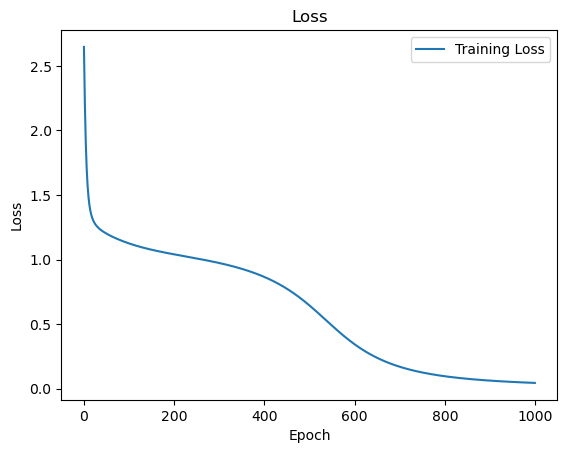

In [40]:
mlp.loss_plot()

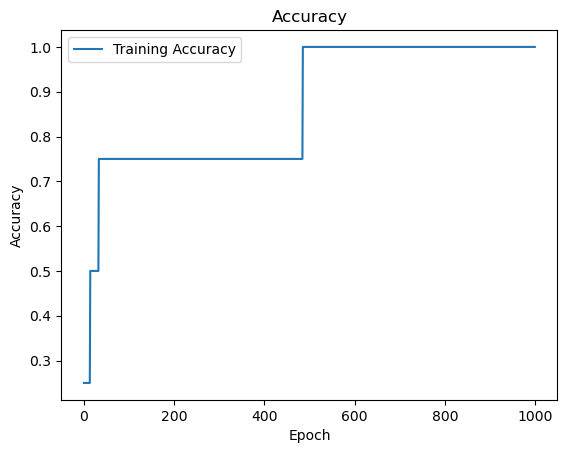

In [41]:
mlp.accuracy_plot()

In [42]:
np.round(mlp.predict(X))

array([[0.],
       [1.],
       [1.],
       [0.]])